# Feature Contribution Analysis
In this notebook, I will examine the feature contributions calculated by LRP. There are two kinds of different contribution scores to every gene:
* A feature contribution that tells us how important each of the features were for the classification of that gene as being a cancer gene
* A neighbor contribution that tells us which of its interacting partners in the PPI were most important for the classification of that gene

Here, we will only look at the feature contributions. We will apply spectral biclustering of the top 1000 EMOGI predictions and see different classes of cancer genes.
The number of clusters is calculated using the eigengap analysis. Furthermore, we check that doing the analysis with all genes yields mainly two clusters for highly and lowly predicted genes, giving not much relevant new information. Also, clustering the input is not as powerful to find distinct classes of cancer genes.

In [1]:
# data science & classics
import pandas as pd
import numpy as np
import h5py
import networkx as nx
import os, sys
import subprocess
import scipy

# clustering & embedding
from sklearn.cluster import SpectralBiclustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster import hierarchy
import umap
import sklearn
from sklearn import preprocessing

# Linear Algebra for eigengap analysis
from scipy.spatial.distance import pdist, squareform
import scipy
from scipy.sparse import csgraph
from numpy import linalg as LA
from sklearn import metrics

# other modules of mine
sys.path.append(os.path.abspath('../EMOGI'))
import gcnIO, postprocessing, utils
sys.path.append(os.path.abspath('../pancancer/preprocessing'))
import preprocessing_utils as pre_utils

# GO enrichment analysis
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.test_data.genes_NCBI_9606_ProteinCoding import GENEID2NT as GeneID2nt_human
from goatools.godag_plot import plot_gos, plot_results, plot_goid2goobj
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
sys.path.append(os.path.abspath('../pancancer'))
import preprocessing_utils as ut

# plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.rc('font', family='Arial')
%matplotlib inline

## Relevant Paths
* `achilles_data_path`: Path to the achilles CRSIPR gene effect csv file that can be downloaded [here](https://depmap.org/portal/download/)
* `model_dir`: Path to the training directory where both, the model and the LRP contributions are stored.

In [2]:
achilles_data_path = '../data/pancancer/Achilles/Achilles_gene_effect.csv'
#model_dir = '../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/'
model_dir = '../data/GCN/training/Rev1_CNA_separated_all_networks/CPDB/'
ncg_cancer_genes_path = '../data/pancancer/NCG/cancergenes_list.txt'
oncokb_path = '../data/pancancer/oncoKB/cancerGeneList.txt'
cgc_path = '../data/pancancer/cosmic/cancer_gene_census.csv'

In [3]:
def get_cancer_genes():
    # get the NCG cancer genes
    known_cancer_genes = []
    candidate_cancer_genes = []
    n = 0
    with open(ncg_cancer_genes_path, 'r') as f:
        for line in f.readlines():
            n += 1
            if n == 1:
                continue
            l = line.strip().split('\t')
            if len(l) == 2:
                known_cancer_genes.append(l[0])
                candidate_cancer_genes.append(l[1])
            else:
                candidate_cancer_genes.append(l[0])

    oncokb_genes = pd.read_csv(oncokb_path, sep='\t')
    return oncokb_genes, known_cancer_genes, candidate_cancer_genes


def plot_rolling_avg(ax, data, window_size=200):
    rolling_avg = data.rolling(window=window_size).median()
    sns.lineplot(x=range(data.shape[0]), y=rolling_avg)
    plt.fill_between(range(data.shape[0]), rolling_avg)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


def get_pathway_enrichment(genes, universe, cluster_idx, out_dir, clean_up=True):
    # write cluster information to disk
    genes.set_index('ID').to_csv(os.path.join(out_dir, 'cluster_{}.tsv'.format(cluster_idx)), sep='\t')
    universe.set_index('ID').to_csv(os.path.join(out_dir, 'universe_cluster_{}.tsv'.format(cluster_idx)), sep='\t')

    # formulate command to hand to R script
    cmd = 'Rscript KEGG.R {} {} {} {}'.format(os.path.join(out_dir, 'cluster_{}.tsv'.format(cluster_idx)),
                                              os.path.join(out_dir, 'universe_cluster_{}.tsv'.format(cluster_idx)),
                                              os.path.join(out_dir, 'cluster_{}_pathways.txt'.format(cluster_idx)),
                                              genes.shape[0]
                                          )
    res = subprocess.call(cmd, shell=True)
    # read pathways and return
    top_pathways = pd.read_csv(os.path.join(model_dir, 'cluster_{}_pathways.txt'.format(cluster_idx)),
                               sep='\t')[['Pvalue', 'Count', 'Size', 'Term']].head(5)
    
    if clean_up:
        os.remove(os.path.join(out_dir, 'cluster_{}.tsv'.format(cluster_idx)))
        os.remove(os.path.join(out_dir, 'universe_cluster_{}.tsv'.format(cluster_idx)))

    return top_pathways


def plot_representative(ax, rep, rep_std, xlabels, title=None):
    if rep_std is None:
        ax.bar(x=np.arange(len(xlabels)), height=rep.values, tick_label=xlabels)
    else:
        ax.bar(x=np.arange(len(xlabels)), height=rep.values, tick_label=xlabels, yerr=rep_std.values)
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', labelsize=10)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    if not title is None:
        ax.set_title(title, fontsize=13)
    ax.set_ylabel('Feature\nContribution', fontsize=15)
    utils.colorize_by_omics(ax, xlabels)


def plot_representative_heatmap(ax, rep, xlabels, title=None):
    rep = rep.reshape(16, 3, order='F')
    inner = gridspec.GridSpecFromSubplotSpec(3, 1, hspace=0, subplot_spec=ax)
    omics = ['Mutation', 'Methylation', 'Expression']
    cmaps = [sns.color_palette("Reds"), sns.color_palette("Blues"), sns.color_palette("Greens")]
    vmax = x.max()
    vmin = x.min()
    print ("Max and min ", vmax, vmin)
    for c in range(3):
        ax = plt.Subplot(fig, inner[c])
        xticklabels = False
        if c == 2:
            xticklabels = [i.split(':')[1] for i in xlabels[:16]]
        sns.heatmap(rep[:, c].reshape(1, -1), ax=ax, xticklabels=xticklabels,
                    cbar=False, cmap=cmaps[c],
                    cbar_kws={'use_gridspec': False, 'orientation': 'vertical'},
                    vmax=vmax, vmin=vmin)
        ax.set_yticklabels([omics[c]], rotation=0, fontsize=10)
        if not title is None and c == 0:
            ax.set_title(title, fontsize=16)
        fig.add_subplot(ax)
    plt.subplots_adjust(bottom=0.05, hspace=0.05, wspace=0)


def plot_pathway_information(ax, pathways):
    for i in range(pathways.shape[0]):
        ax.text(0, 0.9-i*0.2, '{0:.0E}  {1}  {2}  {3}'.format(pathways.iloc[i]['Pvalue'],
                                                              pathways.iloc[i]['Count'],
                                                              pathways.iloc[i]['Size'],
                                                              pathways.iloc[i]['Term']
                                                             ), fontsize=10
               )
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

## Load the LRP Results

In [4]:
args, _ = gcnIO.load_hyper_params(model_dir)
hdf_path = os.path.join(model_dir, args['data'])
with h5py.File(hdf_path, 'r') as f:
    node_names = f['gene_names'][:]
    feature_names = f['feature_names'][:]
    adjacency = f['network'][:]
    features = f['features'][:]
    features_raw = f['features_raw'][:]
feature_contributions = np.load(os.path.join(model_dir, 'lrp_sigmoid', 'feat_mean_all.npy'))
# replace 0 values with small random ones to prevent numerical issues
feat_contrib_df = pd.DataFrame(feature_contributions, index=node_names[:feature_contributions.shape[0], 1], columns=feature_names)
zero_rows = feat_contrib_df[(feat_contrib_df == 0).all(axis=1)]
feat_contrib_df.loc[(feat_contrib_df == 0).all(axis=1)] = np.random.randn(*zero_rows.shape)*0.00001
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])

In [5]:
pred = postprocessing.load_predictions(model_dir)

In [6]:
(feat_contrib_df == 0).all(axis=1).sum()

0

## Clustering of Contribution for Top 1000 Genes

In [7]:
# select only top 1000 predictions
high_feat_contrib = feat_contrib_df[feat_contrib_df.index.isin(pred.head(1000).Name)]
#high_feat_contrib = feat_contrib_df[feat_contrib_df.index.isin(pred[pred.Prob_pos > 0.95].Name)]
high_feat_contrib = high_feat_contrib[high_feat_contrib.sum(axis=1).between(-1, 1)]
print ("Selected {} Genes for Spectral Biclustering".format(high_feat_contrib.shape[0]))

# remove negative contributions
high_feat_contrib_capped = high_feat_contrib.copy()
high_feat_contrib_capped[high_feat_contrib_capped < 0] = 0
#high_feat_contrib_capped[high_feat_contrib_capped > 1] = 1

high_feat_contrib_normed = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(high_feat_contrib_capped),
                                        index=high_feat_contrib.index, columns=high_feat_contrib.columns)

Selected 997 Genes for Spectral Biclustering


### Find Appropriate Number of Clusters using Eigengap Analysis

Optimal number of row clusters [ 52 996 995  53 994]
Optimal number of col clusters [ 5 63  6 62  8]


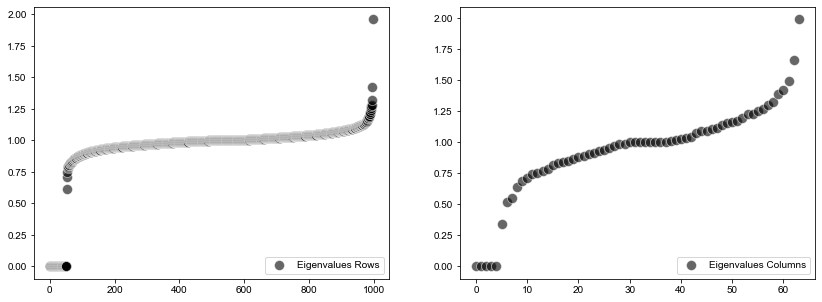

In [8]:
# the code here is copy pasted from https://github.com/ciortanmadalina/high_noise_clustering/blob/master/spectral_clustering.ipynb

def getAffinityMatrix(coordinates, k = 7):
    """
    Calculate affinity matrix based on input coordinates matrix and the numeber
    of nearest neighbours.
    
    Apply local scaling based on the k nearest neighbour
        References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    """
    # calculate euclidian distance matrix
    dists = squareform(pdist(coordinates))
    
    # for each row, sort the distances ascendingly and take the index of the 
    #k-th position (nearest neighbour)
    knn_distances = np.sort(dists, axis=0)[k]
    knn_distances = knn_distances[np.newaxis].T
    
    # calculate sigma_i * sigma_j
    local_scale = knn_distances.dot(knn_distances.T)

    affinity_matrix = dists * dists
    affinity_matrix = -affinity_matrix / local_scale
    # divide square distance matrix by local scale
    affinity_matrix[np.where(np.isnan(affinity_matrix))] = 0.0
    # apply exponential
    affinity_matrix = np.exp(affinity_matrix)
    np.fill_diagonal(affinity_matrix, 0)
    return affinity_matrix


def getAdjacencyMatrix(coordinates, delta=.3):
    # calculate euclidian distance matrix
    dists = squareform(pdist(coordinates, metric='correlation'))
    dists[dists <= delta] = 0
    return dists
    
    
def eigenDecomposition(A, topK = 5):
    """
    :param A: Affinity matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in 
    # the euclidean norm of complex numbers.
    #eigenvalues, eigenvectors = LA.eigh(L)
    eigenvalues, eigenvectors = LA.eig(L)
    idx = eigenvalues.argsort()#[::-1]   
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]
            
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors


affinity_matrix = getAdjacencyMatrix(high_feat_contrib_normed, delta=1.185)
k, evals_row, e_vecs_row = eigenDecomposition(affinity_matrix)
print(f'Optimal number of row clusters {k}')

aff_mat_cols = getAdjacencyMatrix(high_feat_contrib_normed.T, delta=1.054)
k_col, evals_col, evecs_col  = eigenDecomposition(aff_mat_cols)
print(f'Optimal number of col clusters {k_col}')

fig = plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
num_of_evals_to_plot = len(evals_row)
sns.scatterplot(np.arange(num_of_evals_to_plot), evals_row[:num_of_evals_to_plot], label='Eigenvalues Rows', s=100, color='black', alpha=0.6)
#plt.gca().set_xticklabels(range(5, 51, 5))
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
sns.scatterplot(np.arange(len(evals_col)), evals_col, label='Eigenvalues Columns', s=100, color='black', alpha=0.6)
plt.legend(loc='lower right')
fig.savefig(os.path.join(model_dir, 'biclustering_eigengap_analysis.svg'))

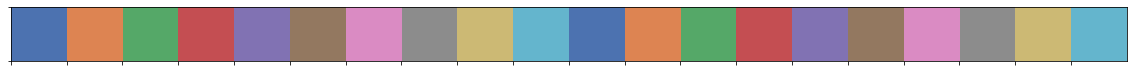

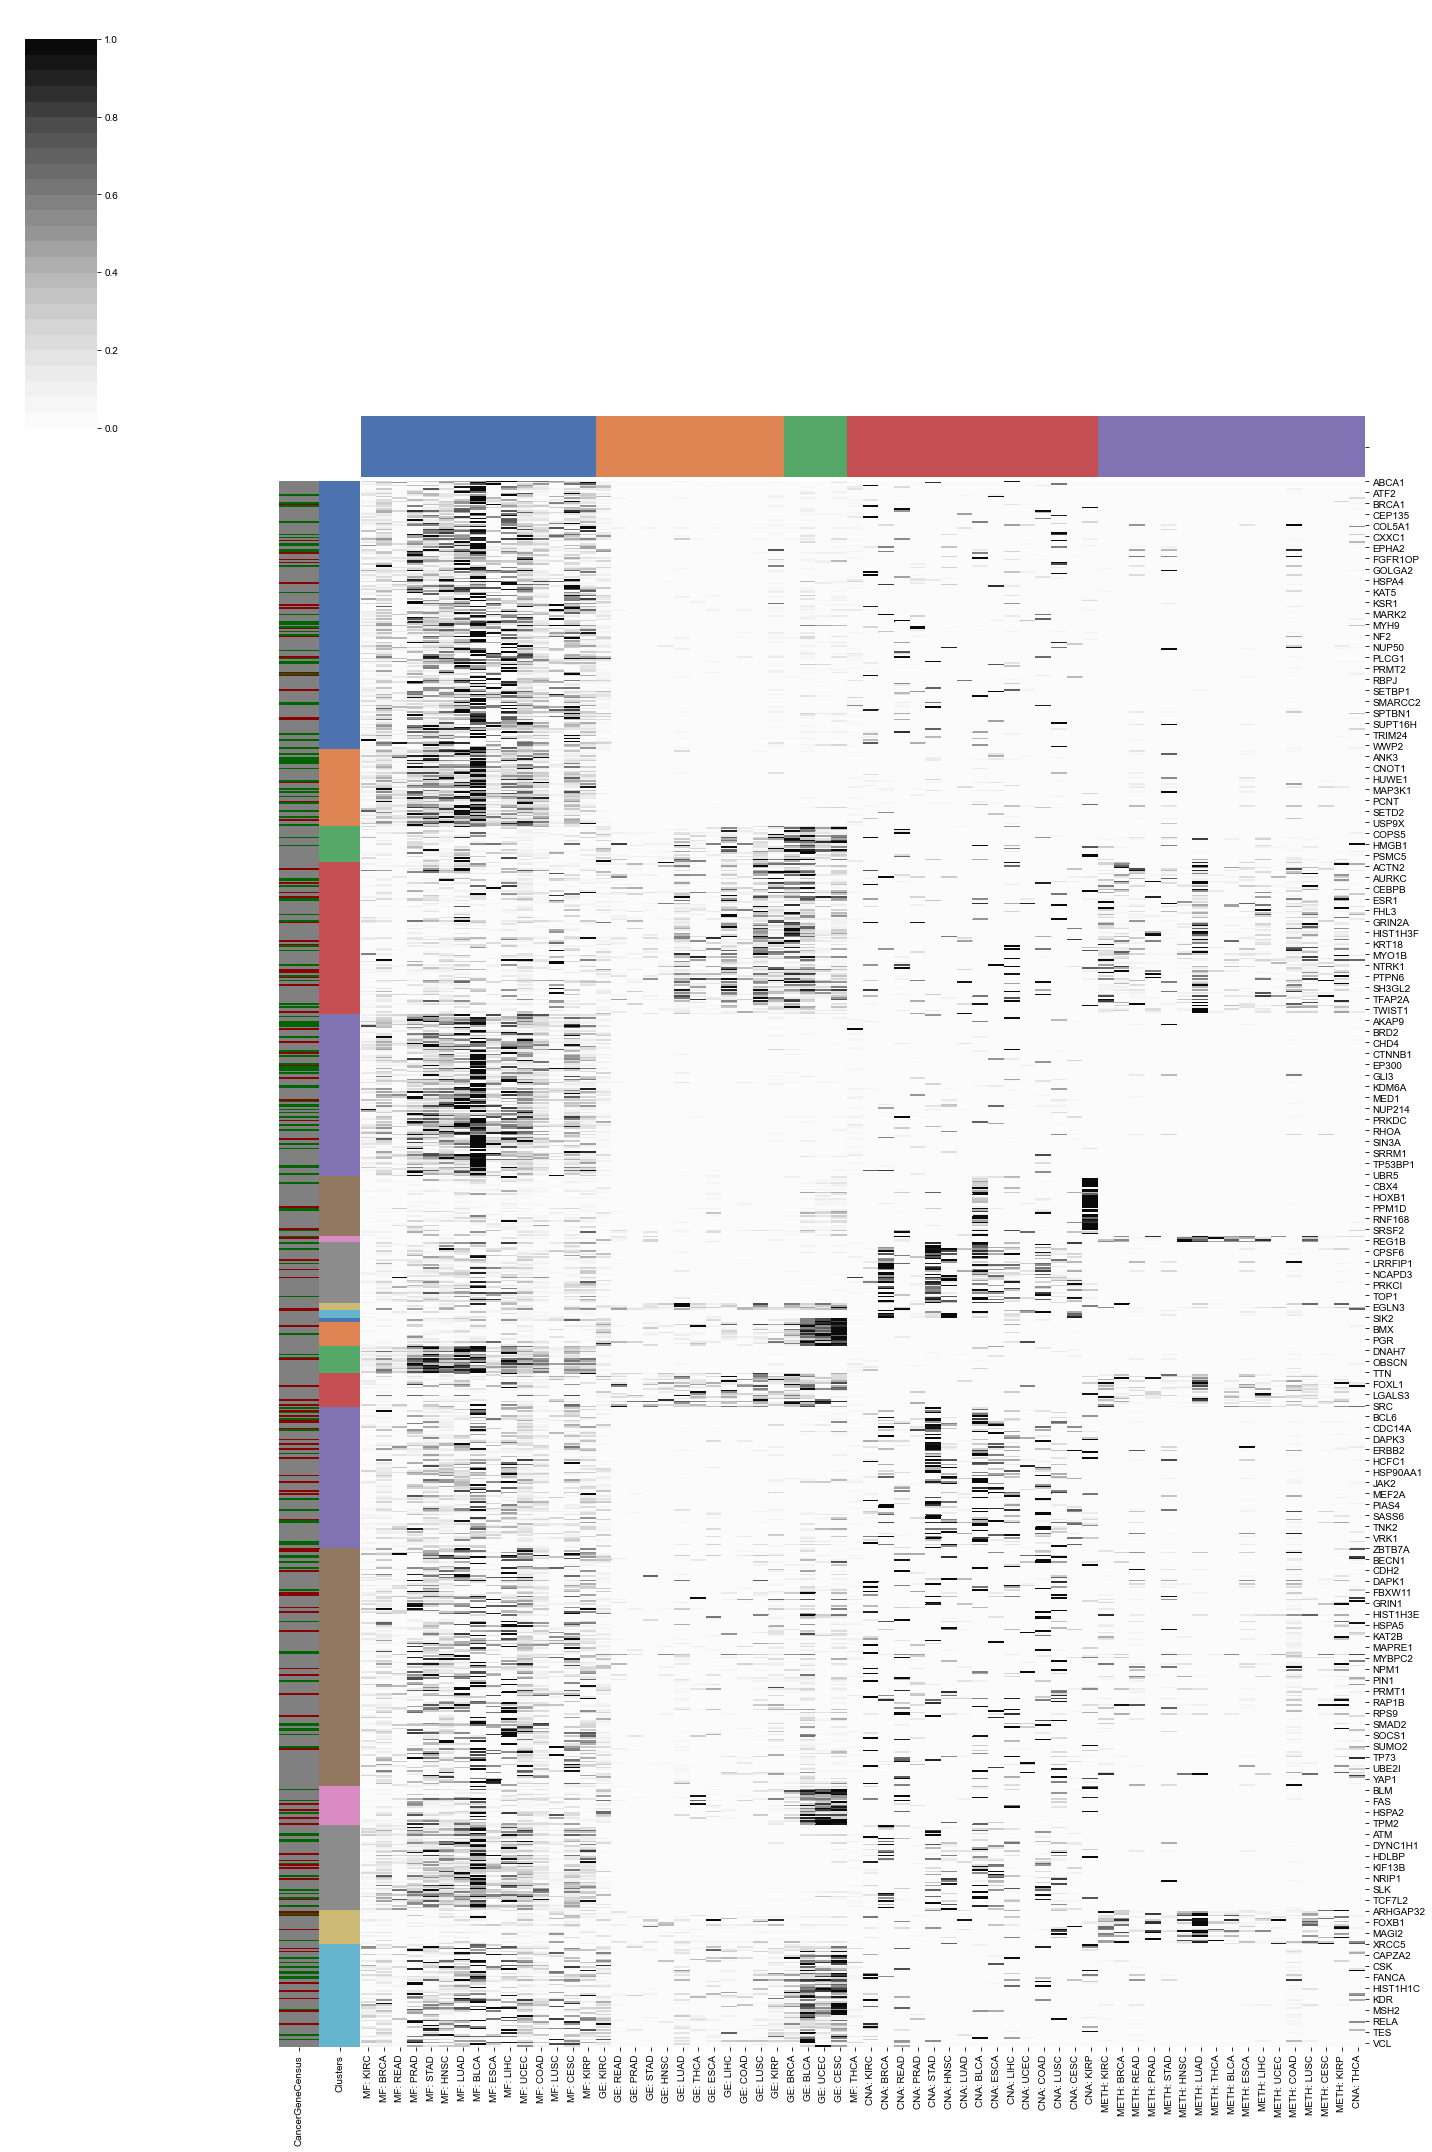

In [9]:
n_clusters = (20, 5) # (20, 6), (20, 5) (17, 6, log method), (25, 5, bistochastic)

model = SpectralBiclustering(n_clusters=n_clusters, method='bistochastic',
                             svd_method='randomized', n_jobs=-1, random_state=0
                            )
model.fit(high_feat_contrib_normed)
newOrder_row = [list(r) for r in zip(model.row_labels_, high_feat_contrib_normed.index)]
newOrder_row.sort(key=lambda k: (k[0], k[1]), reverse=False)
order_row = [i[1] for i in newOrder_row]
newOrder_col = [list(c) for c in zip(model.column_labels_, high_feat_contrib_normed.columns)]
newOrder_col.sort(key=lambda k: k[0], reverse=False)
order_col = [i[1] for i in newOrder_col]

# reorder the data matrix
X_plot = high_feat_contrib_capped.copy()
X_plot = X_plot.reindex(order_row) # rows
X_plot = X_plot[[str(x) for x in order_col]] # columns
X_plot.head()

lut_flatclu = dict(zip(list(range(max(n_clusters))),
                       sns.color_palette("deep", n_colors=max(n_clusters)))
                  )
sns.palplot(lut_flatclu.values())

# get the literature information on known cancer genes
cgc = pd.read_csv('../data/pancancer/cosmic/cancer_gene_census.csv').set_index('Gene Symbol')
onco_tsg_annotation = np.zeros(high_feat_contrib.shape[0])
onco_tsg_annotation[high_feat_contrib.index.isin(cgc[cgc['Role in Cancer'].str.contains('oncogene') == True].index)] = 1
onco_tsg_annotation[high_feat_contrib.index.isin(cgc[cgc['Role in Cancer'].str.contains('TSG') == True].index)] = 2
onco_tsg_annotation = pd.Series(onco_tsg_annotation, index=high_feat_contrib.index, name='CancerGeneCensus')

lut = dict(zip(onco_tsg_annotation.unique(), ['grey', 'darkred', 'darkgreen']))
onco_tsg_colors = onco_tsg_annotation.map(lut)

row_cluster_colors = pd.Series(model.row_labels_, index=high_feat_contrib.index).map(lut_flatclu).rename('Clusters')
row_colors = pd.concat([onco_tsg_colors, row_cluster_colors], axis=1)

# use clustermap without clustering
cm=sns.clustermap(X_plot, method=None, metric='euclidean',
                  #cmap="RdBu_r",
                  cmap=sns.color_palette("Greys", n_colors=25),
                  row_cluster=False, col_cluster=False,
                  row_colors=row_colors,
                  col_colors=pd.Series(model.column_labels_, index=high_feat_contrib.columns).map(lut_flatclu),
                  yticklabels=7, xticklabels=1,
                  figsize=(20, 30),
                  standard_scale=0, z_score=None, robust=False
                 )
#cm.savefig(os.path.join(model_dir, 'biclustering_lrp_highconf_22_5.png'), dpi=300)

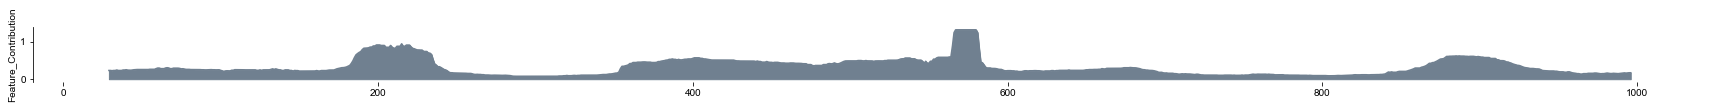

In [10]:
def plot_rolling_avg(ax, data, window_size=20):
    rolling_avg = data.rolling(window=window_size).median()
    sns.lineplot(x=range(data.shape[0]), y=rolling_avg, color='#708090')
    plt.fill_between(range(data.shape[0]), rolling_avg, color='#708090')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    
feat_contrib_cmindex = X_plot.sum(axis=1).rename('Feature_Contribution')
fig = plt.figure(figsize=(30, 1))
ax = plt.subplot(1, 1, 1)
plot_rolling_avg(ax, feat_contrib_cmindex, window_size=30)
#fig.savefig(os.path.join(model_dir, 'biclustering_density_contributions.png'), dpi=300)

In [11]:
# relevant clusters are calculated by row_index * n_columns + col_index
# starting at 0. For instance, the cluster in in the 6th row and 2nd column (brown and orange)
# has number 5 * 5 + 1 = 26
relevant_clusters = [0, 5, 11, 12, 16, 17, 20, 38, 60, 66, 67, 73, 85, 94, 95, 97] # 20, 5
relevant_rows = [0, 1, 2, 3, 4, 7, 12, 13, 14, 17, 18, 19] # 11, 15, 16 are also slightly relevant
#relevant_rows = [0, 1, 2, 6, 7, 8, 10, 12, 14, 15, 17, 18, 19]

#relevant_clusters = [4, 8, 17, 34, 44, 51, 59, 92, 98, 114]# 20, 6
#relevant_clusters = [9, 14, 20, 30, 39, 49, 53, 57, 65, 72, 83, 85, 98, 104] 
#relevant_clusters = [1, 26, 35, 49, 57, 63, 70, 81]

In [12]:
# write the biclusters to disk
count = 1
biclustering_genes_rows = []
processed_rows = []
for cluster_number in relevant_clusters:
    row = cluster_number // n_clusters[1]
    if not row in processed_rows:
        subcluster = high_feat_contrib_normed.iloc[model.get_indices(cluster_number)]
        genes = nodes[nodes.Name.isin(subcluster.index)]
        genes.to_csv(os.path.join(model_dir, 'bicluster_{}.tsv'.format(count)), sep='\t')
        biclustering_genes_rows.append(genes)
        processed_rows.append(row)
        count += 1
assert (processed_rows == relevant_rows)

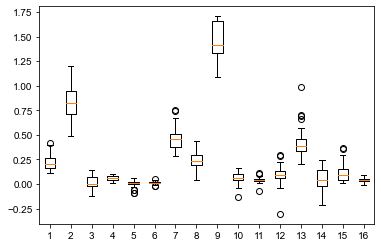

In [13]:
feat_contrib_per_cluster = []
for c in relevant_clusters:
    subcluster = high_feat_contrib.iloc[model.get_indices(c)]
    feat_contrib_per_cluster.append(subcluster.sum(axis=1))
_ = plt.boxplot(feat_contrib_per_cluster)

## Statistics for Clusters

In [14]:
nodes_highconf = pd.DataFrame(high_feat_contrib.index.copy(), columns=['Name']).set_index('Name')
nodes_highconf['Cluster'] = model.row_labels_

#nodes_highconf = nodes_highconf[nodes_highconf.Cluster.isin([0, 1, 2, 5, 7, 8, 9, 10, 16, 19])]
nodes_highconf = nodes_highconf[nodes_highconf.Cluster.isin(relevant_rows)]

# put in the amount of feature contribution
nodes_highconf_pred = nodes_highconf.join(pred.set_index('Name'))
nodes_enriched = nodes_highconf_pred.join(high_feat_contrib.sum(axis=1).rename('Feature_Contribution'))
nodes_enriched.loc[nodes_enriched.Feature_Contribution > 1, 'Feature_Contribution'] = 1
nodes_enriched.loc[nodes_enriched.Feature_Contribution < 0, 'Feature_Contribution'] = 0

# put in the labels (known cancer genes)
nodes_enriched.loc[nodes_enriched.label.isnull(), 'label'] = 0
nodes_enriched.loc[nodes_enriched.label == True, 'label'] = 1
nodes_enriched.loc[nodes_enriched.label == False, 'label'] = 0

# put in number of cancer neighbors
A = pd.DataFrame(adjacency, index=node_names[:, 1], columns=node_names[:, 1])
num_known_neighbors = A[A.index.isin(pred[pred.label == True].Name)].sum(axis=0).rename('Num_Cancer_Gene_Neighbors')
nodes_enriched = nodes_enriched.join(num_known_neighbors)

# put in the number of NPCGs per cluster
npcgs = pd.read_csv('../data/GCN/training/Rev1_CNA_separated_all_networks/consensus_candidates_cnasep.tsv', sep='\t')
#npcgs = pd.read_csv('../data/GCN/training/final_TCGA_all_networks/consensus_candidates.tsv', sep='\t')
npcgs.set_index('Name', inplace=True)
nodes_enriched['NPCG'] = 0
nodes_enriched.loc[nodes_enriched.index.isin(npcgs.index), 'NPCG'] = 1
npcgs_cl = [nodes_enriched[nodes_enriched.Cluster == i].NPCG.sum() for i in range(len(relevant_clusters))]

# get essentiality
essential_genes = pd.read_csv(achilles_data_path).T
essential_genes.columns = essential_genes.loc['Unnamed: 0']
essential_genes.drop('Unnamed: 0', inplace=True)
essential_genes['Name'] = [i.split('(')[0].strip() for i in essential_genes.index]
essential_genes.set_index('Name', inplace=True)
# sum and join with nodes
essentiality = (essential_genes < -0.5).sum(axis=1)
nodes_enriched = nodes_enriched.join(essentiality.rename('essentiality'), how='inner')


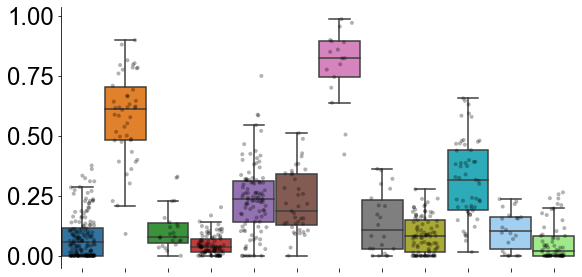

In [15]:
colors = sns.color_palette()[:10] + sns.xkcd_palette(["light blue", "light green", "light brown", "pink", "black", "light red"])

fig = plt.figure(figsize=(8, 4))
sns.boxplot(data=nodes_enriched, x='Cluster', y='Feature_Contribution', showfliers=False, width=0.95,
            palette=colors)
sns.stripplot(data=nodes_enriched, x='Cluster', y='Feature_Contribution', alpha=0.3,
              size=4, color='black', jitter=0.3)
plt.gca().tick_params(axis='both', labelsize=24)
plt.gca().set_xticklabels([])
plt.ylabel(None, fontsize=20)
plt.xlabel(None)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.tight_layout()
#fig.savefig(os.path.join(model_dir, 'cluster_stats_feat_contrib.svg'))

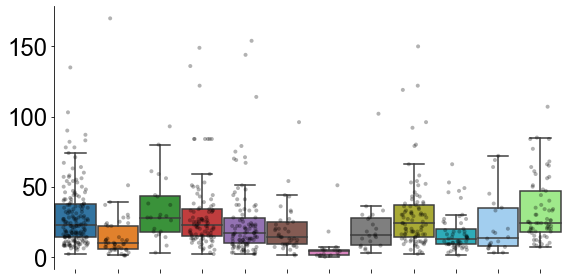

In [16]:
# next, plot the number of known cancer gene neighbors
fig = plt.figure(figsize=(8, 4))
g = sns.boxplot(data=pd.melt(nodes_enriched[['Cluster', 'Num_Cancer_Gene_Neighbors']], id_vars='Cluster'),
            x='Cluster', y='value', showfliers=False, width=.95, palette=colors)
sns.stripplot(data=pd.melt(nodes_enriched[['Cluster', 'Num_Cancer_Gene_Neighbors']], id_vars='Cluster'),
            x='Cluster', y='value', alpha=0.3, size=4, jitter=0.3, color='black')
#g.legend().remove()
plt.gca().tick_params(axis='both', labelsize=24)
plt.gca().set_xticklabels([])
plt.ylabel(None, fontsize=28)
plt.xlabel(None)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.tight_layout()
#fig.savefig(os.path.join(model_dir, 'cluster_stats_neighbors.svg'))

### Enrichment for Essential Genes

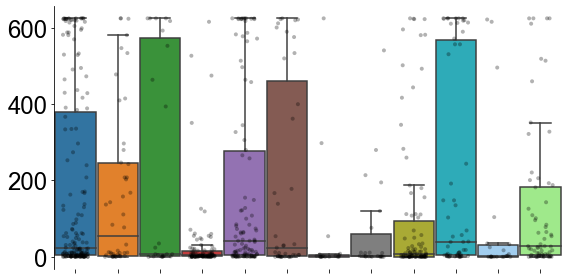

In [17]:
fig = plt.figure(figsize=(8, 4))
g = sns.boxplot(data=pd.melt(nodes_enriched[['Cluster', 'essentiality']], id_vars='Cluster'),
            x='Cluster', y='value', showfliers=False, width=0.95, palette=colors)
sns.stripplot(data=pd.melt(nodes_enriched[['Cluster', 'essentiality']], id_vars='Cluster'),
            x='Cluster', y='value', alpha=0.3, size=4, jitter=0.3, color='black')
#g.legend().remove()
plt.gca().tick_params(axis='both', labelsize=24)
plt.gca().set_xticklabels([])
plt.ylabel(None, fontsize=28)
plt.xlabel(None)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.tight_layout()
#fig.savefig(os.path.join(model_dir, 'cluster_stats_essentiality.svg'))

In [18]:
npcgs_per_cluster = nodes_enriched[['Cluster', 'NPCG']].groupby('Cluster').NPCG.mean()# / npcgs.shape[0]
npcgs_per_cluster

Cluster
0    0.124
1    0.130
2    0.130
3    0.094
4    0.078
7    0.000
12   0.294
13   0.045
14   0.078
17   0.093
18   0.045
19   0.200
Name: NPCG, dtype: float64

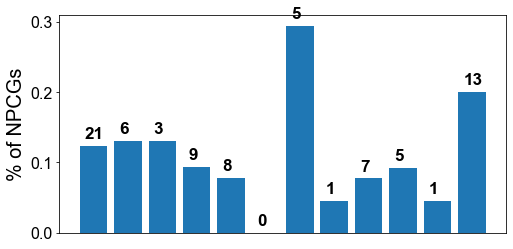

In [19]:
fig = plt.figure(figsize=(8, 4))
npcgs_per_cluster = nodes_enriched[['Cluster', 'NPCG']].groupby('Cluster').NPCG.mean()# / npcgs.shape[0]
npcgs_per_cluster_nums = nodes_enriched[['Cluster', 'NPCG']].groupby('Cluster').NPCG.sum()# / npcgs.shape[0]
x_vals = np.arange(1, nodes_enriched.Cluster.nunique()+1)
plt.bar(x=x_vals,
        height=npcgs_per_cluster)

for i in x_vals:
    plt.gca().text(i-0.25, npcgs_per_cluster.iloc[i-1] + .01,
            str(npcgs_per_cluster_nums.iloc[i-1]), color='black', fontweight='bold', fontsize=17)

plt.ylabel('% of NPCGs', fontsize=20)
plt.gca().tick_params(axis='both', labelsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#_ = plt.xticks(np.arange(1, len(relevant_clusters)+1), labels=['Cluster {}'.format(i+1) for i in range(len(relevant_clusters))],
#               rotation=90, fontsize=20)
fig.savefig(os.path.join(model_dir, 'cluster_stats_npcgs.svg'))

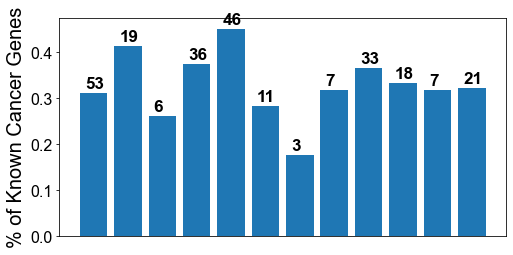

In [20]:
fig = plt.figure(figsize=(8, 4))
kcgs_per_cluster = nodes_enriched[['Cluster', 'label']].astype(float).groupby('Cluster').label.mean()# / npcgs.shape[0]
kcgs_per_cluster_nums = nodes_enriched[['Cluster', 'label']].astype(float).groupby('Cluster').label.sum()# / npcgs.shape[0]

plt.bar(x=np.arange(1, nodes_enriched.Cluster.nunique()+1),
        height=kcgs_per_cluster)

for i in x_vals:
    plt.gca().text(i-0.25, kcgs_per_cluster.iloc[i-1] + .01,
            str(int(kcgs_per_cluster_nums.iloc[i-1])), color='black', fontweight='bold', fontsize=17)

plt.ylabel('% of Known Cancer Genes', fontsize=20)
plt.gca().tick_params(axis='both', labelsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#_ = plt.xticks(np.arange(1, len(relevant_clusters)+1), labels=['Cluster {}'.format(i+1) for i in range(len(relevant_clusters))],
#               rotation=90, fontsize=20)
#plt.ylim([0.1, 0.48])
fig.savefig(os.path.join(model_dir, 'cluster_stats_knowns.svg'))

In [21]:
nodes_enriched[nodes_enriched.Cluster == 7]

,Cluster,label,Num_Pos,Prob_pos,Std_Pred,NCG_Known_Cancer_Gene,NCG_Candidate_Cancer_Gene,OncoKB_Cancer_Gene,Bailey_et_al_Cancer_Gene,ONGene_Oncogene,Feature_Contribution,Num_Cancer_Gene_Neighbors,NPCG,essentiality
Name,,,,,,,,,,,,,,
YEATS4,7,0,10,0.994,0.011,False,True,False,False,True,0.000,26.000,0,620
CASP3,7,1,10,1.000,0.000,True,False,False,False,False,0.087,43.000,0,0
MYC,7,1,10,1.000,0.000,True,False,True,True,True,0.099,96.000,0,622
TJP1,7,0,10,0.999,0.002,False,False,False,False,False,0.134,14.000,0,10
CDKN2A,7,1,10,0.997,0.003,True,False,True,True,False,0.319,14.000,0,4
TOP1,7,1,10,1.000,0.000,True,False,True,False,False,0.254,44.000,0,576
BMI1,7,0,10,0.999,0.002,False,False,False,False,True,0.339,54.000,0,5
BCL2L1,7,1,10,0.999,0.001,False,False,True,False,True,0.142,20.000,0,520
NFATC1,7,0,10,1.000,0.000,False,False,False,False,False,0.094,33.000,0,0


## Pathway Enrichment and GO Enrichment

In [22]:
cluster_pathways_highconf = []
processed_rows = []
c = 1
for cluster_number in relevant_clusters:
    row = cluster_number // n_clusters[1]
    if not row in processed_rows:
        subcluster = high_feat_contrib.iloc[model.get_indices(cluster_number)]
        genes = nodes[nodes.Name.isin(subcluster.index)]
        top_pathways = get_pathway_enrichment(genes, nodes, c, model_dir, clean_up=False)
        cluster_pathways_highconf.append((row, top_pathways))
        processed_rows.append(row)
        c += 1
assert (processed_rows == relevant_rows)

In [23]:
high_feat = pd.DataFrame(features_raw,
                         index=node_names[:feature_contributions.shape[0], 1],
                         columns=feature_names
                        )
high_feat = high_feat[high_feat.index.isin(high_feat_contrib_normed.index)]
(high_feat.index == high_feat_contrib_normed.index).all()

True

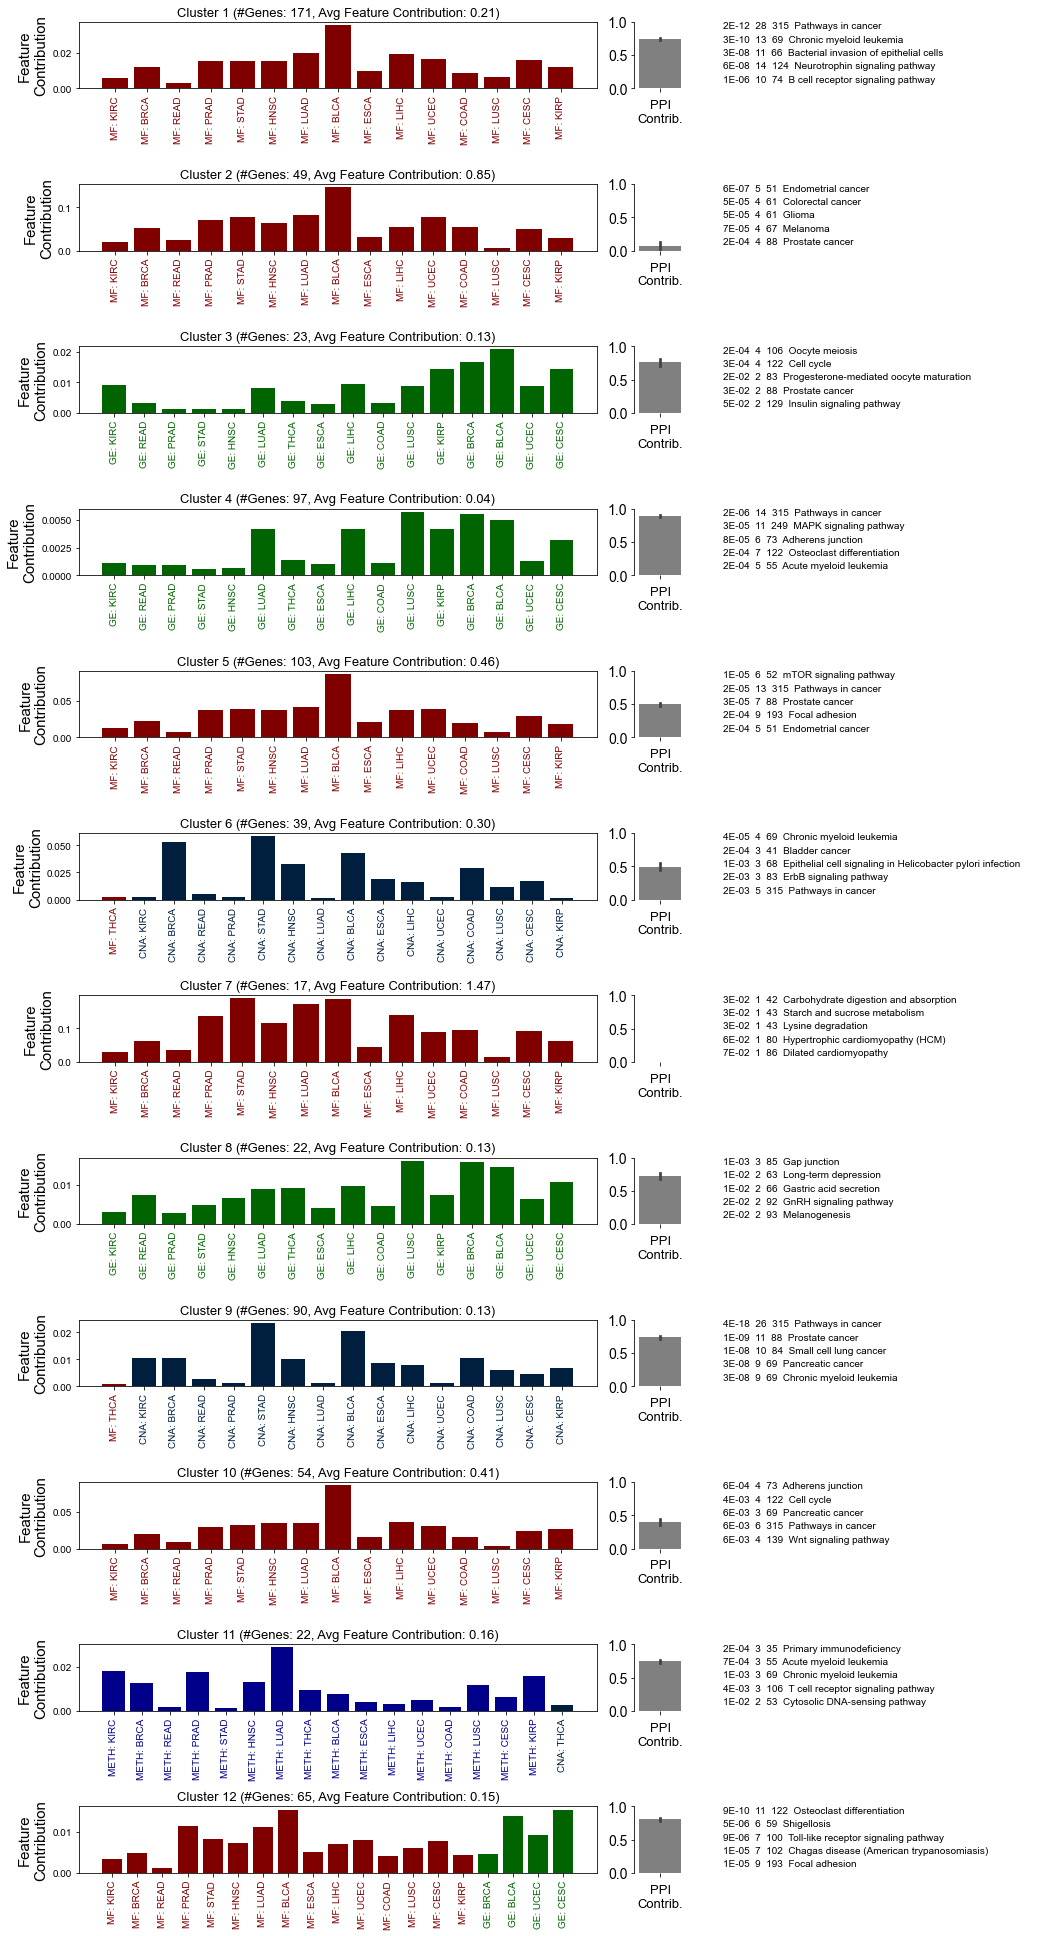

In [25]:
fig, axes = plt.subplots(nrows=len(relevant_rows), ncols=3,
                         figsize=(15, len(relevant_clusters)*1.5 + 3),
                         gridspec_kw={'width_ratios': [5, 0.5, 3]}
                        )

plot_count = 0
for row_cluster in relevant_rows:
    clusters_for_row = [i for i in relevant_clusters if i // n_clusters[1] == row_cluster]

    # find the genes in the current cluster
    indices = [[], []]
    for c in clusters_for_row:
        idx_r, idx_c = model.get_indices(c)
        indices[0] += list(idx_r)
        indices[1] += list(idx_c)
    subcluster = high_feat_contrib_capped.iloc[tuple(indices)]
    genes = nodes[nodes.Name.isin(subcluster.index)]
    
    # compute the representative for that cluster
    representative = subcluster.mean(axis=0)
    representative_std = subcluster.std(axis=0)
    # plot barplot for representative
    plot_representative(axes[plot_count][0], representative, None, subcluster.columns.tolist(),
             title='Cluster {0} (#Genes: {1}, Avg Feature Contribution: {2:.2f})'.format(plot_count + 1,
                                                                                         genes.shape[0],
                                                                                         representative.sum()
                                                                                        )
            )

    # get network and feature contributions for the cluster
    all_features_cluster = high_feat_contrib_capped[high_feat_contrib_capped.index.isin(genes.Name)]
    sns.barplot(1-all_features_cluster.sum(axis=1), ax=axes[plot_count][1], orient='v', color='grey')
    axes[plot_count][1].set_ylim([0, 1])
    axes[plot_count][1].set_xlabel('PPI\nContrib.', fontsize=13)
    axes[plot_count][1].spines['right'].set_visible(False)
    axes[plot_count][1].spines['top'].set_visible(False)
    axes[plot_count][1].spines['bottom'].set_visible(False)
    axes[plot_count][1].tick_params(axis='y', labelsize=14)

    # plot the pathways next to it
    plot_pathway_information(axes[plot_count][2], cluster_pathways_highconf[plot_count][1])
    plot_count += 1

plt.tight_layout()
fig.savefig(os.path.join(model_dir, 'bicluster_representatives_highconf_all.pdf'))

## GO Enrichment for Biclusters

In [29]:
# Get the data
obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()
obodag = GODag("go-basic.obo")
objanno = Gene2GoReader(fin_gene2go, taxids=[9606])

ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated human genes".format(NS=nspc, N=len(id2gos)))

goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_human.keys(), # List of human protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method

  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2020-07-16) 47,259 GO Terms
HMS:0:00:06.383270 338,121 annotations READ: gene2go 
1 taxids stored: 9606
MF 18,162 annotated human genes
CC 19,414 annotated human genes
BP 18,597 annotated human genes

Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 81% 16,864 of 20,913 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 85% 17,853 of 20,913 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 83% 17,359 of 20,913 population items found in association


In [30]:
cluster_i = 1
for cluster_number in relevant_clusters:
    # find the genes in the current cluster
    subcluster = high_feat_contrib_capped.iloc[model.get_indices(cluster_number)]
    genes = nodes[nodes.Name.isin(subcluster.index)]
    geneids_study = [int(i) for i in list(ut.get_entrez_from_symbol(genes.Name).index) if not i is None]
    goea_results_all = goeaobj.run_study(geneids_study)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    #plot_results(os.path.join(out_dir, 'SCC_{}_goenrichment.png'.format(comp+1)), goea_results_sig)
    goeaobj.wr_xlsx(os.path.join(model_dir, 'BiCluster_{}_goenrichment.xlsx'.format(cluster_i)), goea_results_sig)
    cluster_i += 1

querying 1-171...done.
Finished.
1 input query terms found no hit:
	['FGFR1OP']

Run BP Gene Ontology Analysis: current study set of 170 IDs ...
 99%    169 of    170 study items found in association
100%    170 of    170 study items found in population(20913)
Calculating 12,274 uncorrected p-values using fisher_scipy_stats
  12,274 GO terms are associated with 16,864 of 20,913 population items
   1,896 GO terms are associated with    169 of    170 study items
  METHOD fdr_bh:
     101 GO terms found significant (< 0.05=alpha) (101 enriched +   0 purified): statsmodels fdr_bh
     154 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 170 IDs ...
100%    170 of    170 study items found in association
100%    170 of    170 study items found in population(20913)
Calculating 1,754 uncorrected p-values using fisher_scipy_stats
   1,754 GO terms are associated with 

## Enrichment for Additional Classes of Cancer Genes

['BLCA',
 'BRCA',
 'CESC',
 'COAD',
 'GBM',
 'HNSC',
 'KIRC',
 'KIRP',
 'LAML',
 'LGG',
 'LIHC',
 'LUAD',
 'LUSC',
 'OV',
 'SKCM',
 'STAD']

In [36]:
# read the excel file
prognosis_expression = pd.ExcelFile('../data/pancancer/prognostic_genes/anaya_et_al_prognostic_genes_expression.xlsx')
our_ctypes = list(set([i.split(':')[1].strip() for i in feature_names]))
all_prognosis_dfs = []
for cancer_type in prognosis_expression.sheet_names:
    if cancer_type.strip() in our_ctypes:
        prognosis_genes_ctype = prognosis_expression.parse(cancer_type)
        # extract top 300 significant genes
        prognosis_genes_ctype = prognosis_genes_ctype[prognosis_genes_ctype['BH  Adjusted P-Value'] < 0.05]
        prognosis_genes_ctype = prognosis_genes_ctype.head(300)
        print ("[{}]: Prognosis Genes: {}".format(cancer_type, len(prognosis_genes_ctype)))
        all_prognosis_dfs.append(prognosis_genes_ctype)

# concatenate to obtain one nice DF without duplicates
expression_prognosis_genes = pd.concat(all_prognosis_dfs).dropna(axis=1)
expression_prognosis_genes.drop_duplicates(subset='Gene Name', inplace=True)
expression_prognosis_genes.set_index('Gene Name', inplace=True)
expression_prognosis_genes.head()

[BLCA]: Prognosis Genes: 300
[BRCA]: Prognosis Genes: 30
[CESC]: Prognosis Genes: 146
[COAD]: Prognosis Genes: 0
[HNSC]: Prognosis Genes: 45
[KIRC]: Prognosis Genes: 300
[KIRP]: Prognosis Genes: 300
[LIHC]: Prognosis Genes: 2
[LUAD]: Prognosis Genes: 300
[LUSC]: Prognosis Genes: 0
[STAD]: Prognosis Genes: 0


In [48]:
#prognostic_genes = pd.read_csv('../data/pancancer/prognostic_genes/wee_et_al_prognostic_genes.csv', sep='\t')
prognostic_genes = pd.read_excel('../data/pancancer/prognostic_genes/wee_et_al_cnaderived_filtered.xlsx') # based on CNAs
prognostic_genes.set_index('Gene', inplace=True)
nodes_enriched['prognostic'] = False
nodes_enriched.loc[nodes_enriched.index.isin(prognostic_genes.index), 'prognostic'] = True

nodes_enriched['expr_prognostic'] = False
nodes_enriched.loc[nodes_enriched.index.isin(expression_prognosis_genes.index), 'expr_prognostic'] = True

metastatic_genes_df = pd.read_excel('../data/pancancer/priestley_et_al_metastatic/41586_2019_1689_MOESM10_ESM.xlsx', sheet_name=0)
metastatic_genes = metastatic_genes_df.gene.unique()
nodes_enriched['metastatic'] = False
#nodes_enriched.loc[~nodes_enriched.label & nodes_enriched.index.isin(metastatic_genes), 'metastatic'] = True
nodes_enriched.loc[nodes_enriched.index.isin(metastatic_genes), 'metastatic'] = True

driverdb_cancer_gene_path = '../data/pancancer/driverdb/'
evidence_drivers = {}
for evidence in ['mutation', 'CNV', 'methylation']:
    driverdb_data = pd.read_csv(os.path.join(driverdb_cancer_gene_path, '{}_download_tab.txt'.format(evidence)), sep='\t')
    drivers = []
    for index, row in driverdb_data.iterrows():
        drivers += [i.strip() for i in row.driver_gene.split(',') if not i.strip() == '']
    evidence_drivers[evidence] = list(set(drivers))
    nodes_enriched['{}_driver'.format(evidence)] = False
    nodes_enriched.loc[nodes_enriched.index.isin(evidence_drivers[evidence]), '{}_driver'.format(evidence)] = True

ci_genes = pd.read_csv('../data/pancancer/ongene_tsgene/Human_initiation_genes.txt', sep='\t')
nodes_enriched['tumor_initiation'] = False
nodes_enriched.loc[nodes_enriched.index.isin(ci_genes.GeneSymbol), 'tumor_initiation'] = True

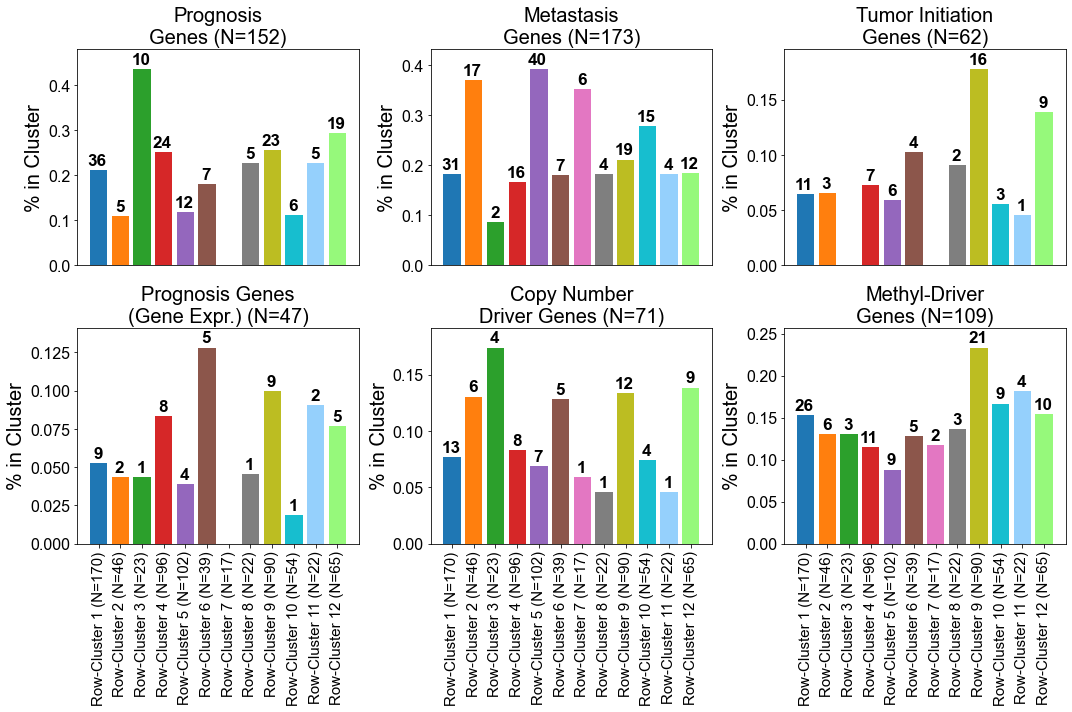

In [51]:
mapping = {'prognostic': 'Prognosis\nGenes', 'metastatic' : 'Metastasis\nGenes', 
           'tumor_initiation': 'Tumor Initiation\nGenes', 'expr_prognostic': 'Prognosis Genes\n(Gene Expr.)',
           'mutation_driver': 'Mut-Driver\nGenes',
           'CNV_driver': 'Copy Number\nDriver Genes', 'methylation_driver': 'Methyl-Driver\nGenes'}
colors_mpl = sns.color_palette().as_hex()[:10] + sns.xkcd_palette(["light blue", "light green"]).as_hex()
n_clusters = nodes_enriched.Cluster.nunique()
def plot_enrichment(ax, data, column, plot_x=False):
    vals_clusters = nodes_enriched[['Cluster', column]].groupby('Cluster')[column].mean()
    abs_nums = nodes_enriched[['Cluster', column]].groupby('Cluster')[column].sum()
    x_vals = np.arange(1, n_clusters+1)
    ax.bar(x=x_vals, height=vals_clusters, color=colors_mpl)
    ax.tick_params(axis='both', labelsize=16)
    ax.set_title('{} (N={})'.format(mapping[column], nodes_enriched[column].sum()), fontsize=20)
    ax.set_ylabel('% in Cluster', fontsize=20)

    # plot the number on top
    ax.set_ylim([0, vals_clusters.max() + vals_clusters.max()/10.])
    for i in x_vals:
        if vals_clusters.iloc[i-1] > 0:
            digit_len = len(str(int(abs_nums.iloc[i-1])))
            ax.text(i-0.25*digit_len, vals_clusters.iloc[i-1] + vals_clusters.max()/40.,
                    str(int(abs_nums.iloc[i-1])), color='black', fontweight='bold', fontsize=17)
    if plot_x:
        _ = ax.set_xticks(np.arange(1, data.Cluster.nunique()+1))
        _ = ax.set_xticklabels(
                   labels=['Row-Cluster {} (N={})'.format(i+1, (data.Cluster == relevant_rows[i]).sum()) for i in range(n_clusters)],
                   rotation=90, fontsize=15)
    else:
        ax.set_xticks([])

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
ax_count = 0

cols = ['prognostic', 'metastatic', 'tumor_initiation', 'expr_prognostic', 'CNV_driver', 'methylation_driver']

for c in cols:
    row_n = ax_count // 3
    col_n = ax_count % 3
    plot_enrichment(axes[row_n][col_n], nodes_enriched, c, row_n == 1)
    ax_count += 1
plt.tight_layout()
fig.savefig(os.path.join(model_dir, 'driver_genes_per_cluster.pdf'))

### Significance of Feature Contributions vs. Network

In [105]:
clust_of_interest = nodes_enriched.Feature_Contribution
for c in nodes_enriched.Cluster.unique():
    genes_in_cluster = nodes_enriched[nodes_enriched.Cluster == c]
    feat_contrib_cluster = genes_in_cluster.Feature_Contribution
    _, pval = scipy.stats.ttest_ind(clust_of_interest, feat_contrib_cluster)
    print ('Cluster {}\tP-value: {}'.format(c, pval))

Cluster 3	P-value: 2.8822803615346114e-07
Cluster 15	P-value: 4.374424620533513e-15
Cluster 14	P-value: 0.003685960998256315
Cluster 1	P-value: 1.337022199923484e-47
Cluster 4	P-value: 5.965660877233045e-06
Cluster 13	P-value: 0.8463556936191362
Cluster 0	P-value: 9.830710061901911e-06
Cluster 17	P-value: 2.074943126026779e-10
Cluster 2	P-value: 0.3832574358091093
Cluster 18	P-value: 0.3216491589088793
Cluster 19	P-value: 0.00018029316380088674
Cluster 7	P-value: 0.011717248838830338
Cluster 11	P-value: 0.41620863391927
Cluster 12	P-value: 1.3168651042760308e-40


In [106]:
npcgs = pd.read_csv('../data/GCN/training/Rev1_CNA_separated_all_networks/consensus_candidates_cnasep.tsv', sep='\t')
npcgs_old = pd.read_csv('../data/GCN/training/final_TCGA_all_networks/consensus_candidates.tsv', sep='\t')
npcgs_in_top1000 = npcgs[npcgs.Name.isin(high_feat_contrib.index)]
npcgs_old_top1000 = npcgs_old[npcgs_old.Name.isin(high_feat_contrib.index)]
npcgs_in_top1000.shape, npcgs_old_top1000.shape

((122, 5), (133, 5))

In [107]:
nodes_enriched[nodes_enriched.index.isin(npcgs.Name)].shape

(112, 9)

### Enrichment for metastatic genes

## Significance for clusters

In [63]:
for c in nodes_enriched.Cluster.unique():
    genes_in_cluster = nodes_enriched[nodes_enriched.Cluster == c]
    npcgs_in_cluster = genes_in_cluster.NPCG.sum()
    non_npcgs_in_cluster = genes_in_cluster.shape[0] - npcgs_in_cluster
    npcgs_non_cluster = nodes_enriched[~nodes_enriched.index.isin(genes_in_cluster)].NPCG.sum()
    nonnpcgs_non_cluster = nodes_enriched.shape[0] - npcgs_non_cluster
    cont = [[npcgs_in_cluster, npcgs_non_cluster], [non_npcgs_in_cluster, nonnpcgs_non_cluster]]

    # do fishers exact test
    odds_ratio, pvalue = scipy.stats.fisher_exact(cont)
    print ("Cluster {}\tP-value: {}\tOdds-Ratio: {}".format(c, pvalue, odds_ratio))

Cluster 3	P-value: 0.8596359203662919	Odds-Ratio: 0.8734177215189873
Cluster 14	P-value: 0.5803419803801453	Odds-Ratio: 0.7120634436480098
Cluster 1	P-value: 0.6212031235246296	Odds-Ratio: 1.2664556962025317
Cluster 4	P-value: 0.48738595248994465	Odds-Ratio: 0.718556423377323
Cluster 13	P-value: 0.7188555522761702	Odds-Ratio: 0.40204942736588306
Cluster 0	P-value: 0.4971460113582187	Odds-Ratio: 1.1899583722708351
Cluster 17	P-value: 1.0	Odds-Ratio: 0.8615344872126066
Cluster 2	P-value: 0.7274743628113416	Odds-Ratio: 1.2664556962025317
Cluster 18	P-value: 0.7188555522761702	Odds-Ratio: 0.40204942736588306
Cluster 19	P-value: 0.03812674124298146	Odds-Ratio: 2.1107594936708862
Cluster 7	P-value: 0.025818252049152488	Odds-Ratio: 0.0
Cluster 12	P-value: 0.030539930350567835	Odds-Ratio: 3.5179324894514767


In [64]:
clust_of_interest = nodes_enriched.essentiality
for c in nodes_enriched.Cluster.unique():
    genes_in_cluster = nodes_enriched[nodes_enriched.Cluster == c]
    essentiality_cluster = genes_in_cluster.essentiality
    whate, pval = scipy.stats.ttest_ind(clust_of_interest, essentiality_cluster)
    print ('Cluster {}\tP-value: {}'.format(c, pval))
    print (whate)

Cluster 3	P-value: 3.443329707970544e-06
4.673775010478648
Cluster 14	P-value: 0.09385000714290972
1.677343629068843
Cluster 1	P-value: 0.44628056859485254
-0.7620115079583899
Cluster 4	P-value: 0.22649177997470574
-1.210326234486077
Cluster 13	P-value: 0.12922098997534753
1.5188177456013354
Cluster 0	P-value: 0.046676620713734525
-1.9919234493684774
Cluster 17	P-value: 0.013832565535244836
-2.467037746389203
Cluster 2	P-value: 0.06050103768774124
-1.879896217617278
Cluster 18	P-value: 0.29642906005458575
1.0448345239699892
Cluster 19	P-value: 0.6471162748398257
0.4579431254362721
Cluster 7	P-value: 0.16095092389124968
-1.4032090684073397
Cluster 12	P-value: 0.13664949980266713
1.4899584085968713


In [68]:
nodes_highconf = pd.DataFrame(high_feat_contrib.index.copy(), columns=['Name']).set_index('Name')
nodes_highconf['Cluster'] = model.row_labels_
nodes_highconf = nodes_highconf.join(essentiality.rename('essentiality'), how='left')
nodes_highconf.loc[nodes_highconf.essentiality.isnull(), 'essentiality'] = 0

genes_in_cluster = nodes_highconf[nodes_highconf.Cluster == 14] # cluster 7 in figure 5
essential_in_cluster = (genes_in_cluster.essentiality > essentiality.mean()).sum()
non_essential_in_cluster = (genes_in_cluster.essentiality <= essentiality.mean()).sum()
essential_non_cluster = (nodes_highconf[~nodes_highconf.index.isin(genes_in_cluster)].essentiality > essentiality.mean()).sum()
nonessential_non_cluster = (nodes_highconf[~nodes_highconf.index.isin(genes_in_cluster)].essentiality <= essentiality.mean()).sum()
cont = [[essential_in_cluster, essential_non_cluster], [non_essential_in_cluster, nonessential_non_cluster]]

# do fishers exact test
odds_ratio, pvalue = scipy.stats.fisher_exact(cont)
print ("P-value: {}\tOdds-Ratio: {}".format(pvalue, odds_ratio))

P-value: 0.12943615102075245	Odds-Ratio: 0.6814281883993207


## Correlation between LRP Features and Essentiality

In [24]:
disease_study_map = {'BLCA': 'Bladder Cancer', 'BRCA': 'Breast Cancer',
                     'READ': 'Colon/Colorectal Cancer', 'PRAD': 'Prostate Cancer',
                     'CESC': 'Cervical Cancer', 'COAD': 'Colon/Colorectal Cancer',
                     'KIRC': 'Kidney Cancer', 'ESCA': 'Esophageal Cancer',
                     'KIRP': 'Kidney Cancer', 'LIHC': 'Liver Cancer',
                     'LUAD': 'Lung Cancer', 'LUSC': 'Lung Cancer',
                     'STAD': 'Gastric Cancer', 'THCA': 'Thyroid Cancer',
                     'HNSC': 'Head and Neck Cancer', 'UCEC': 'Endometrial/Uterine Cancer'}
inv_map = {v: k for k, v in disease_study_map.items()}

cellline_info = pd.read_csv('../data/pancancer/Achilles/sample_info.csv')
cellline_info['tcga_study'] = cellline_info.disease.map(inv_map)

all_corrs = []
genes_processed = []
for gene in feat_contrib_df[feat_contrib_df.index.isin(npcgs.index)].index:
#for gene in feat_contrib_df.index:
    if gene in essential_genes.index:
        affected_celllines = (essential_genes[essential_genes.index == gene] < -0.5).T
        meta_for_gene = cellline_info[cellline_info.DepMap_ID.isin(affected_celllines.index[affected_celllines[gene] == True])]
        celllines_gene = pd.DataFrame(meta_for_gene.tcga_study.value_counts())
        background = pd.DataFrame(cellline_info.tcga_study.value_counts())
        background.columns = ['background']
        with_background = celllines_gene.join(background)
        celllines_gene = with_background.tcga_study / with_background.background
        celllines_gene.rename('tcga_study', inplace=True)
        omics_correlations = []
        for omics in ['MF', 'CNA', 'METH', 'GE']:
            omics_subset = feat_contrib_df.loc[:, feat_contrib_df.columns.str.contains(omics)]
            omics_ranked_for_gene = omics_subset[omics_subset.index == gene].T
            omics_ranked_for_gene.columns = ['LRP']
            omics_ranked_for_gene['idx'] = [x[1].strip() for x in omics_ranked_for_gene.index.str.split(':')]
            omics_ranked_for_gene.set_index('idx', inplace=True)
            together = omics_ranked_for_gene.join(celllines_gene, how='inner')
            rho, pval = scipy.stats.spearmanr(together.LRP, together.tcga_study)
            omics_correlations.append(rho)
        all_corrs.append(omics_correlations)
        genes_processed.append(gene)
all_corrs = pd.DataFrame(all_corrs, index=genes_processed, columns=['Mutation', 'Copy Number', 'Methylation', 'Expression'])

/pkg/python-3.7.7-0/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/pkg/python-3.7.7-0/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/pkg/python-3.7.7-0/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/pkg/python-3.7.7-0/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/pkg/python-3.7.7-0/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


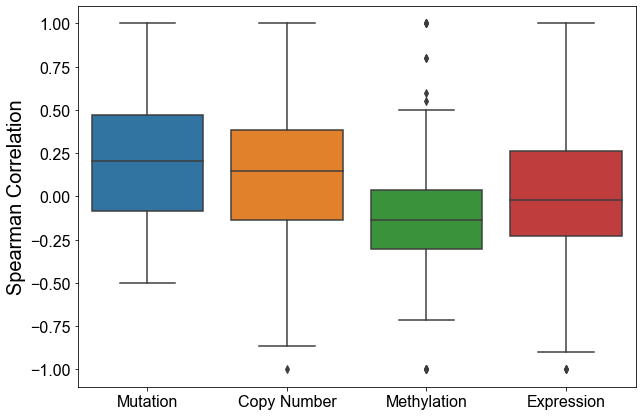

In [25]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=all_corrs.melt(), x='variable', y='value')
plt.ylabel('Spearman Correlation', fontsize=20)
plt.xlabel(None)
plt.tick_params(axis='both', labelsize=16)
fig.savefig(os.path.join(model_dir, 'npcgs_correlation_lrp_essentiality.svg'))

In [23]:
all_corrs.mean(axis=0)

Mutation       0.034
Copy Number   -0.001
Methylation   -0.018
Expression     0.006
dtype: float64

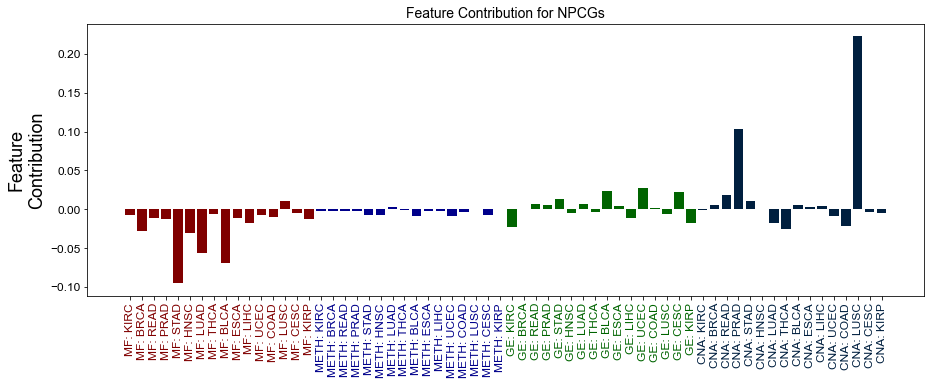

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=1,
                         figsize=(15, 5)
                        )


# compute the representative for that cluster
feat_contrib_npcg = feat_contrib_df[feat_contrib_df.index.isin(npcgs.index)]
representative = feat_contrib_npcg.mean(axis=0)
representative_std = feat_contrib_npcg.std(axis=0)
# plot barplot for representative
plot_representative(axes, representative, None, feat_contrib_npcg.columns.tolist(),
         title='Feature Contribution for NPCGs'
        )

Text(0.5, 1.0, 'Affected Cell Lines for NPCGs')

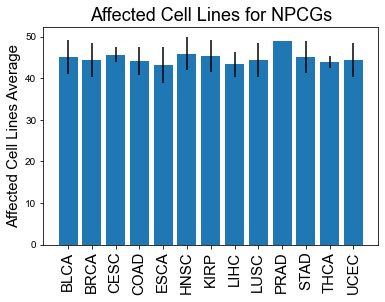

In [42]:
npcgs_essentiality = essential_genes[essential_genes.index.isin(npcgs.index)]
cellline_meta_npcgs = cellline_info.join((npcgs_essentiality < -0.5).sum(axis=0).rename('Essentiality_NPCGs'), on='DepMap_ID')
celllines_tcga_npcgs = cellline_meta_npcgs.groupby('tcga_study').Essentiality_NPCGs.mean()
celllines_tcga_npcgs_std = cellline_meta_npcgs.groupby('tcga_study').Essentiality_NPCGs.std()
plt.bar(x=list(range(celllines_tcga_npcgs.shape[0])), height=celllines_tcga_npcgs, yerr=celllines_tcga_npcgs_std)
_ = plt.xticks(list(range(celllines_tcga_npcgs.shape[0])), labels=celllines_tcga_npcgs.index, rotation=90, fontsize=15)
plt.ylabel('Affected Cell Lines Average', fontsize=15)
plt.title('Affected Cell Lines for NPCGs', fontsize=18)

111 126


Text(0.5, 0, '')

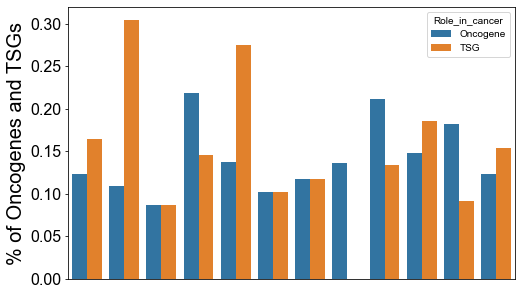

In [26]:
nodes_enriched['Oncogene'] = 0
nodes_enriched['TSG'] = 0
oncogenes = cgc[cgc['Role in Cancer'].str.contains('oncogene') == True].index
tsgs = cgc[cgc['Role in Cancer'].str.contains('TSG') == True].index
nodes_enriched.loc[nodes_enriched.index.isin(oncogenes), 'Oncogene'] = 1
nodes_enriched.loc[nodes_enriched.index.isin(tsgs), 'TSG'] = 1
print (nodes_enriched.Oncogene.sum(), nodes_enriched.TSG.sum())

fig = plt.figure(figsize=(8, 5))
oncogenes_per_cluster = pd.DataFrame(nodes_enriched[['Cluster', 'Oncogene']].groupby('Cluster').Oncogene.mean().rename('value'))# / npcgs.shape[0]
tsgs_per_cluster = pd.DataFrame(nodes_enriched[['Cluster', 'TSG']].groupby('Cluster').TSG.mean().rename('value'))# / npcgs.shape[0]
oncogenes_per_cluster['Role_in_cancer'] = 'Oncogene'
tsgs_per_cluster['Role_in_cancer'] = 'TSG'
combined = pd.concat((oncogenes_per_cluster, tsgs_per_cluster))
combined['Cluster'] = combined.index
sns.barplot(data=combined, x='Cluster', y='value', hue='Role_in_cancer')
plt.ylabel('% of Oncogenes and TSGs', fontsize=20)
plt.gca().tick_params(axis='both', labelsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.xlabel(None)

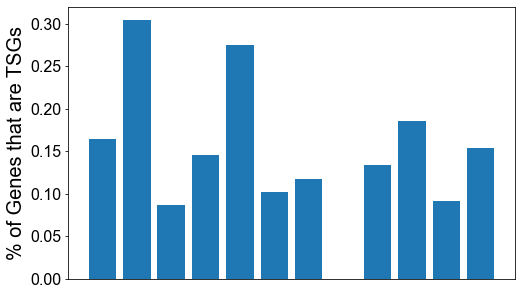

In [27]:
fig = plt.figure(figsize=(8, 5))
tsgs_per_cluster = nodes_enriched[['Cluster', 'TSG']].groupby('Cluster').TSG.mean()# / npcgs.shape[0]
plt.bar(x=np.arange(1, nodes_enriched.Cluster.nunique()+1),
        height=tsgs_per_cluster)
plt.ylabel('% of Genes that are TSGs', fontsize=20)
plt.gca().tick_params(axis='both', labelsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#_ = plt.xticks(np.arange(1, len(relevant_clusters)+1), labels=['Cluster {}'.format(i+1) for i in range(len(relevant_clusters))],
#               rotation=90, fontsize=20)
#fig.savefig(os.path.join(model_dir, 'cluster_stats_knowns.svg'))

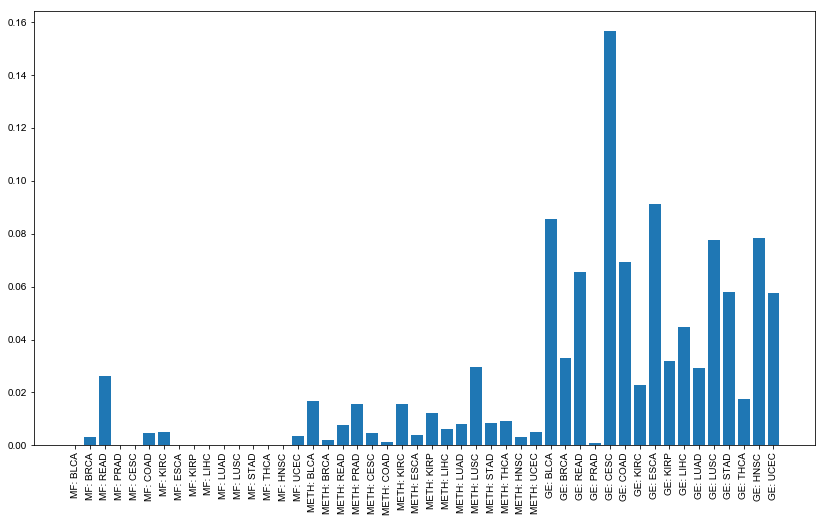

In [37]:
features_df = pd.DataFrame(features, index=node_names[:, 1], columns=feature_names)
fig = plt.figure(figsize=(14, 8))
plt.bar(x=list(range(high_feat_contrib.shape[1])),
        height=features_df[features_df.index == 'CDK2'].values.reshape(-1))
_ = plt.xticks(list(range(features_df.shape[1])), labels=features_df.columns, rotation=90)

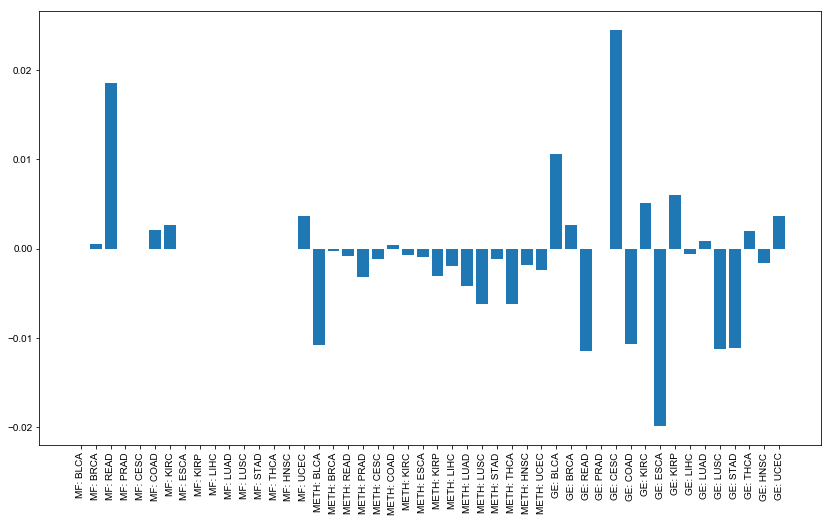

In [38]:
fig = plt.figure(figsize=(14, 8))
plt.bar(x=list(range(high_feat_contrib.shape[1])),
        height=high_feat_contrib[high_feat_contrib.index == 'CDK2'].values.reshape(-1))
_ = plt.xticks(list(range(high_feat_contrib.shape[1])), labels=high_feat_contrib.columns, rotation=90)

In [39]:
high_feat_contrib.iloc[:, 16:32].mean(axis=1).sort_values(ascending=False).head()

REG3A    0.044
REG1B    0.038
HAVCR1   0.034
LILRB2   0.030
TLX3     0.021
dtype: float64

## Sanity Check: What do Silhouette Scores Say About the Optimal Number of Clusters

In [41]:
scores = []
combinations = []
for num_row_clusters in range(10, 20):
    for num_col_clusters in range(3, 10):
        #print (num_row_clusters, num_col_clusters)
        model = SpectralBiclustering(n_clusters=(num_row_clusters, num_col_clusters), method='bistochastic',
                                     svd_method='randomized', n_jobs=-1#, random_state=0
                                    )
        model.fit(high_feat_contrib_normed)
        score = metrics.silhouette_score(high_feat_contrib_normed, model.row_labels_ ,metric='euclidean')
        combinations.append((num_row_clusters, num_col_clusters))
        scores.append(score)

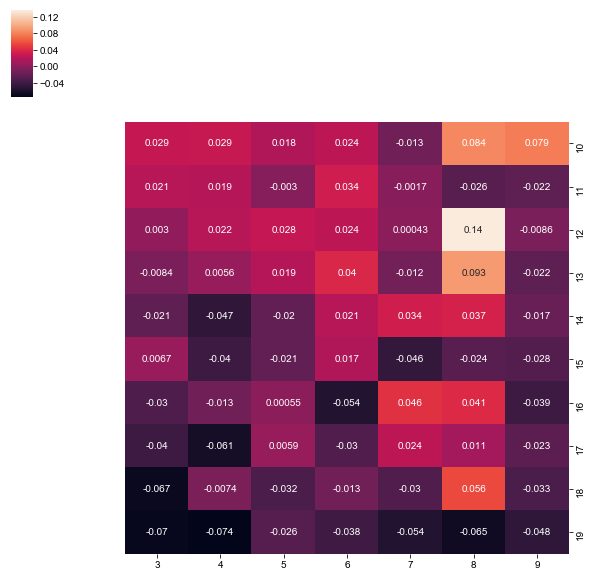

In [42]:
x = np.zeros((pd.Series(([i[0] for i in combinations])).nunique(),
              pd.Series(([i[1] for i in combinations])).nunique())
            )
x = pd.DataFrame(x, index=range(10, 20), columns=range(3, 10))
for i in range(len(combinations)):
    x.loc[combinations[i][0], combinations[i][1]] = scores[i]
sns.clustermap(x, method=None, row_cluster=False, col_cluster=False, annot=True)

## Sanity Check: Biclustering of the *Input Features*
This is a sanity check to see what comes out when looking at only the input data.

Selected 1000 Genes for Spectral Biclustering


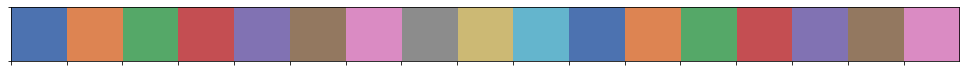

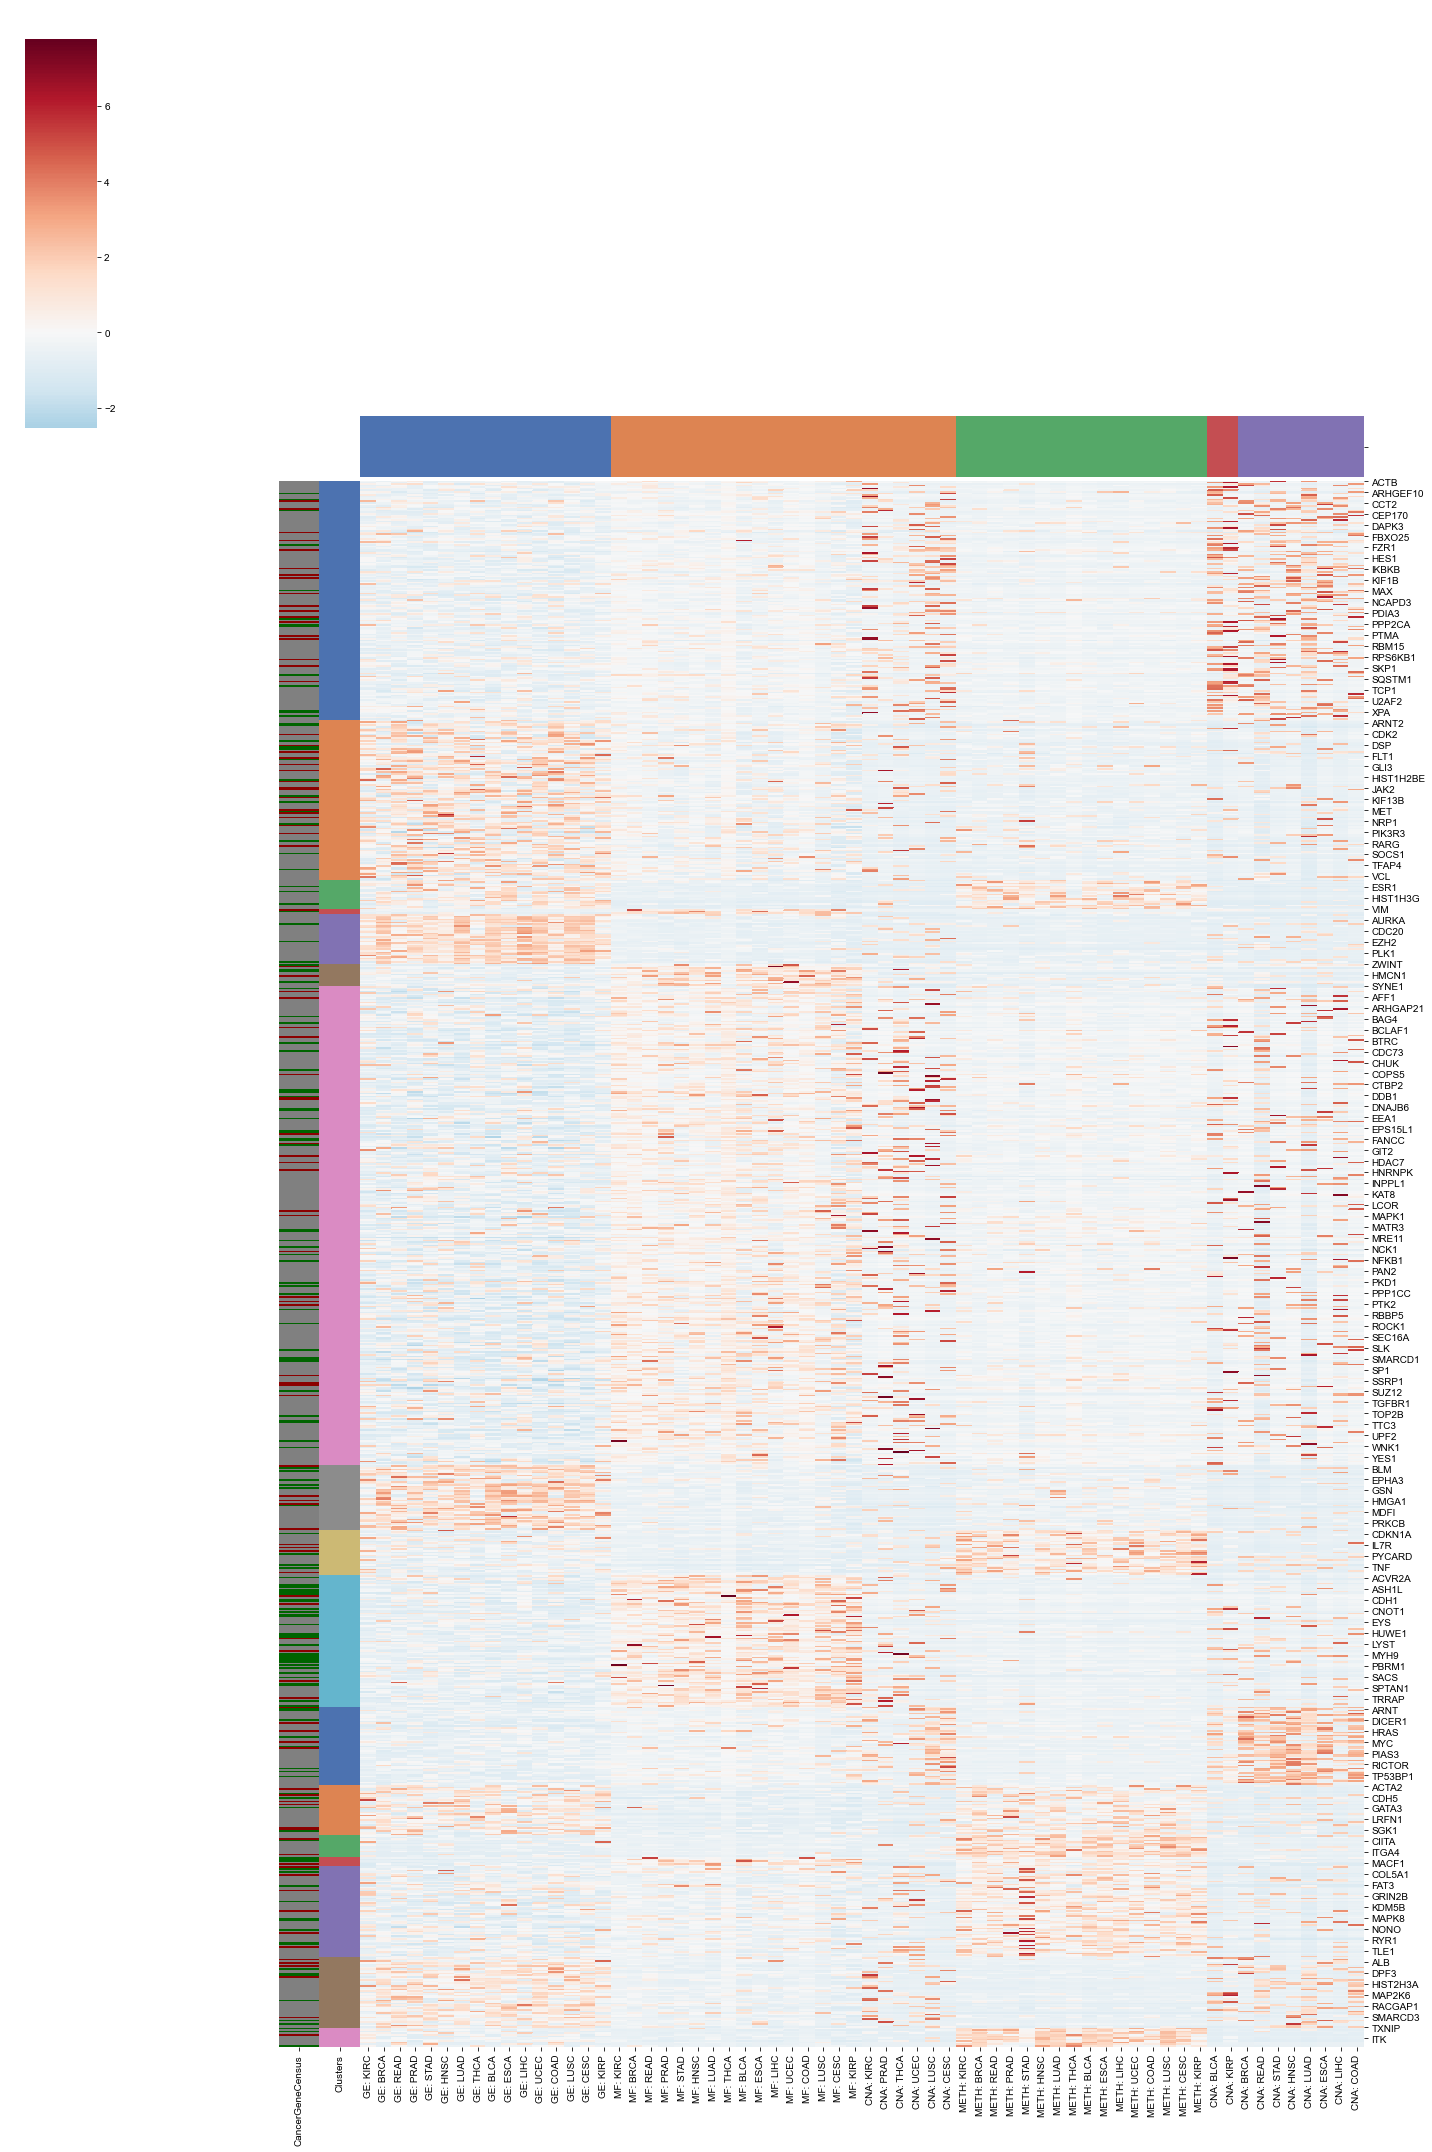

In [94]:
# select only top 1000 predictions
features_df = pd.DataFrame(features, index=node_names[:, 1], columns=feature_names)
features_top1000 = features_df[features_df.index.isin(pred.head(1000).Name)]
print ("Selected {} Genes for Spectral Biclustering".format(features_top1000.shape[0]))

# do the spectral biclustering
n_clusters = (17, 5)
features_top1000_normed = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(features_top1000),
                                        index=features_top1000.index, columns=features_top1000.columns)
model = SpectralBiclustering(n_clusters=n_clusters, method='bistochastic',
                             svd_method='randomized', n_jobs=-1, random_state=0
                            )
model.fit(features_top1000_normed)

# get new row and column orders
newOrder_row = [list(r) for r in zip(model.row_labels_, features_top1000_normed.index)]
newOrder_row.sort(key=lambda k: (k[0], k[1]), reverse=False)
order_row = [i[1] for i in newOrder_row]
newOrder_col = [list(c) for c in zip(model.column_labels_, features_top1000_normed.columns)]
newOrder_col.sort(key=lambda k: k[0], reverse=False)
order_col = [i[1] for i in newOrder_col]

# reorder the data matrix
X_plot = features_top1000_normed.copy()
X_plot = X_plot.reindex(order_row) # rows
X_plot = X_plot[[str(x) for x in order_col]] # columns

# get the clusters as colormaps to show on the side
lut_flatclu = dict(zip(list(range(max(n_clusters))),
                       sns.color_palette("deep", n_colors=max(n_clusters)))
                  )
sns.palplot(lut_flatclu.values())

# get some information on known cancer genes (oncogenes vs TSGs vs unknown)
cgc = pd.read_csv(cgc_path).set_index('Gene Symbol')
onco_tsg_annotation = np.zeros(features_top1000_normed.shape[0])
onco_tsg_annotation[features_top1000_normed.index.isin(cgc[cgc['Role in Cancer'].str.contains('oncogene') == True].index)] = 1
onco_tsg_annotation[features_top1000_normed.index.isin(cgc[cgc['Role in Cancer'].str.contains('TSG') == True].index)] = 2
onco_tsg_annotation = pd.Series(onco_tsg_annotation, index=features_top1000_normed.index, name='CancerGeneCensus')

lut = dict(zip(onco_tsg_annotation.unique(), ['grey', 'darkred', 'darkgreen']))
onco_tsg_colors = onco_tsg_annotation.map(lut)

row_cluster_colors = pd.Series(model.row_labels_, index=features_top1000_normed.index).map(lut_flatclu).rename('Clusters')
row_colors = pd.concat([onco_tsg_colors, row_cluster_colors], axis=1)

# use clustermap without clustering
cm=sns.clustermap(X_plot, method=None, metric='correlation',
                  cmap="RdBu_r",
                  #cmap=sns.color_palette("Greys", n_colors=25),
                  row_cluster=False, col_cluster=False,
                  row_colors=row_colors,
                  col_colors=pd.Series(model.column_labels_, index=features_top1000_normed.columns).map(lut_flatclu),
                  yticklabels=7, xticklabels=1,
                  figsize=(20, 30),
                  standard_scale=None, z_score=False, robust=False, center=0
                 )
cm.savefig(os.path.join(model_dir, 'biclustering_input_top1000.png'), dpi=300)

## Sanity Check: Biclustering of Contributions *of All Genes*

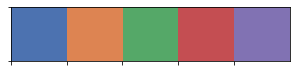

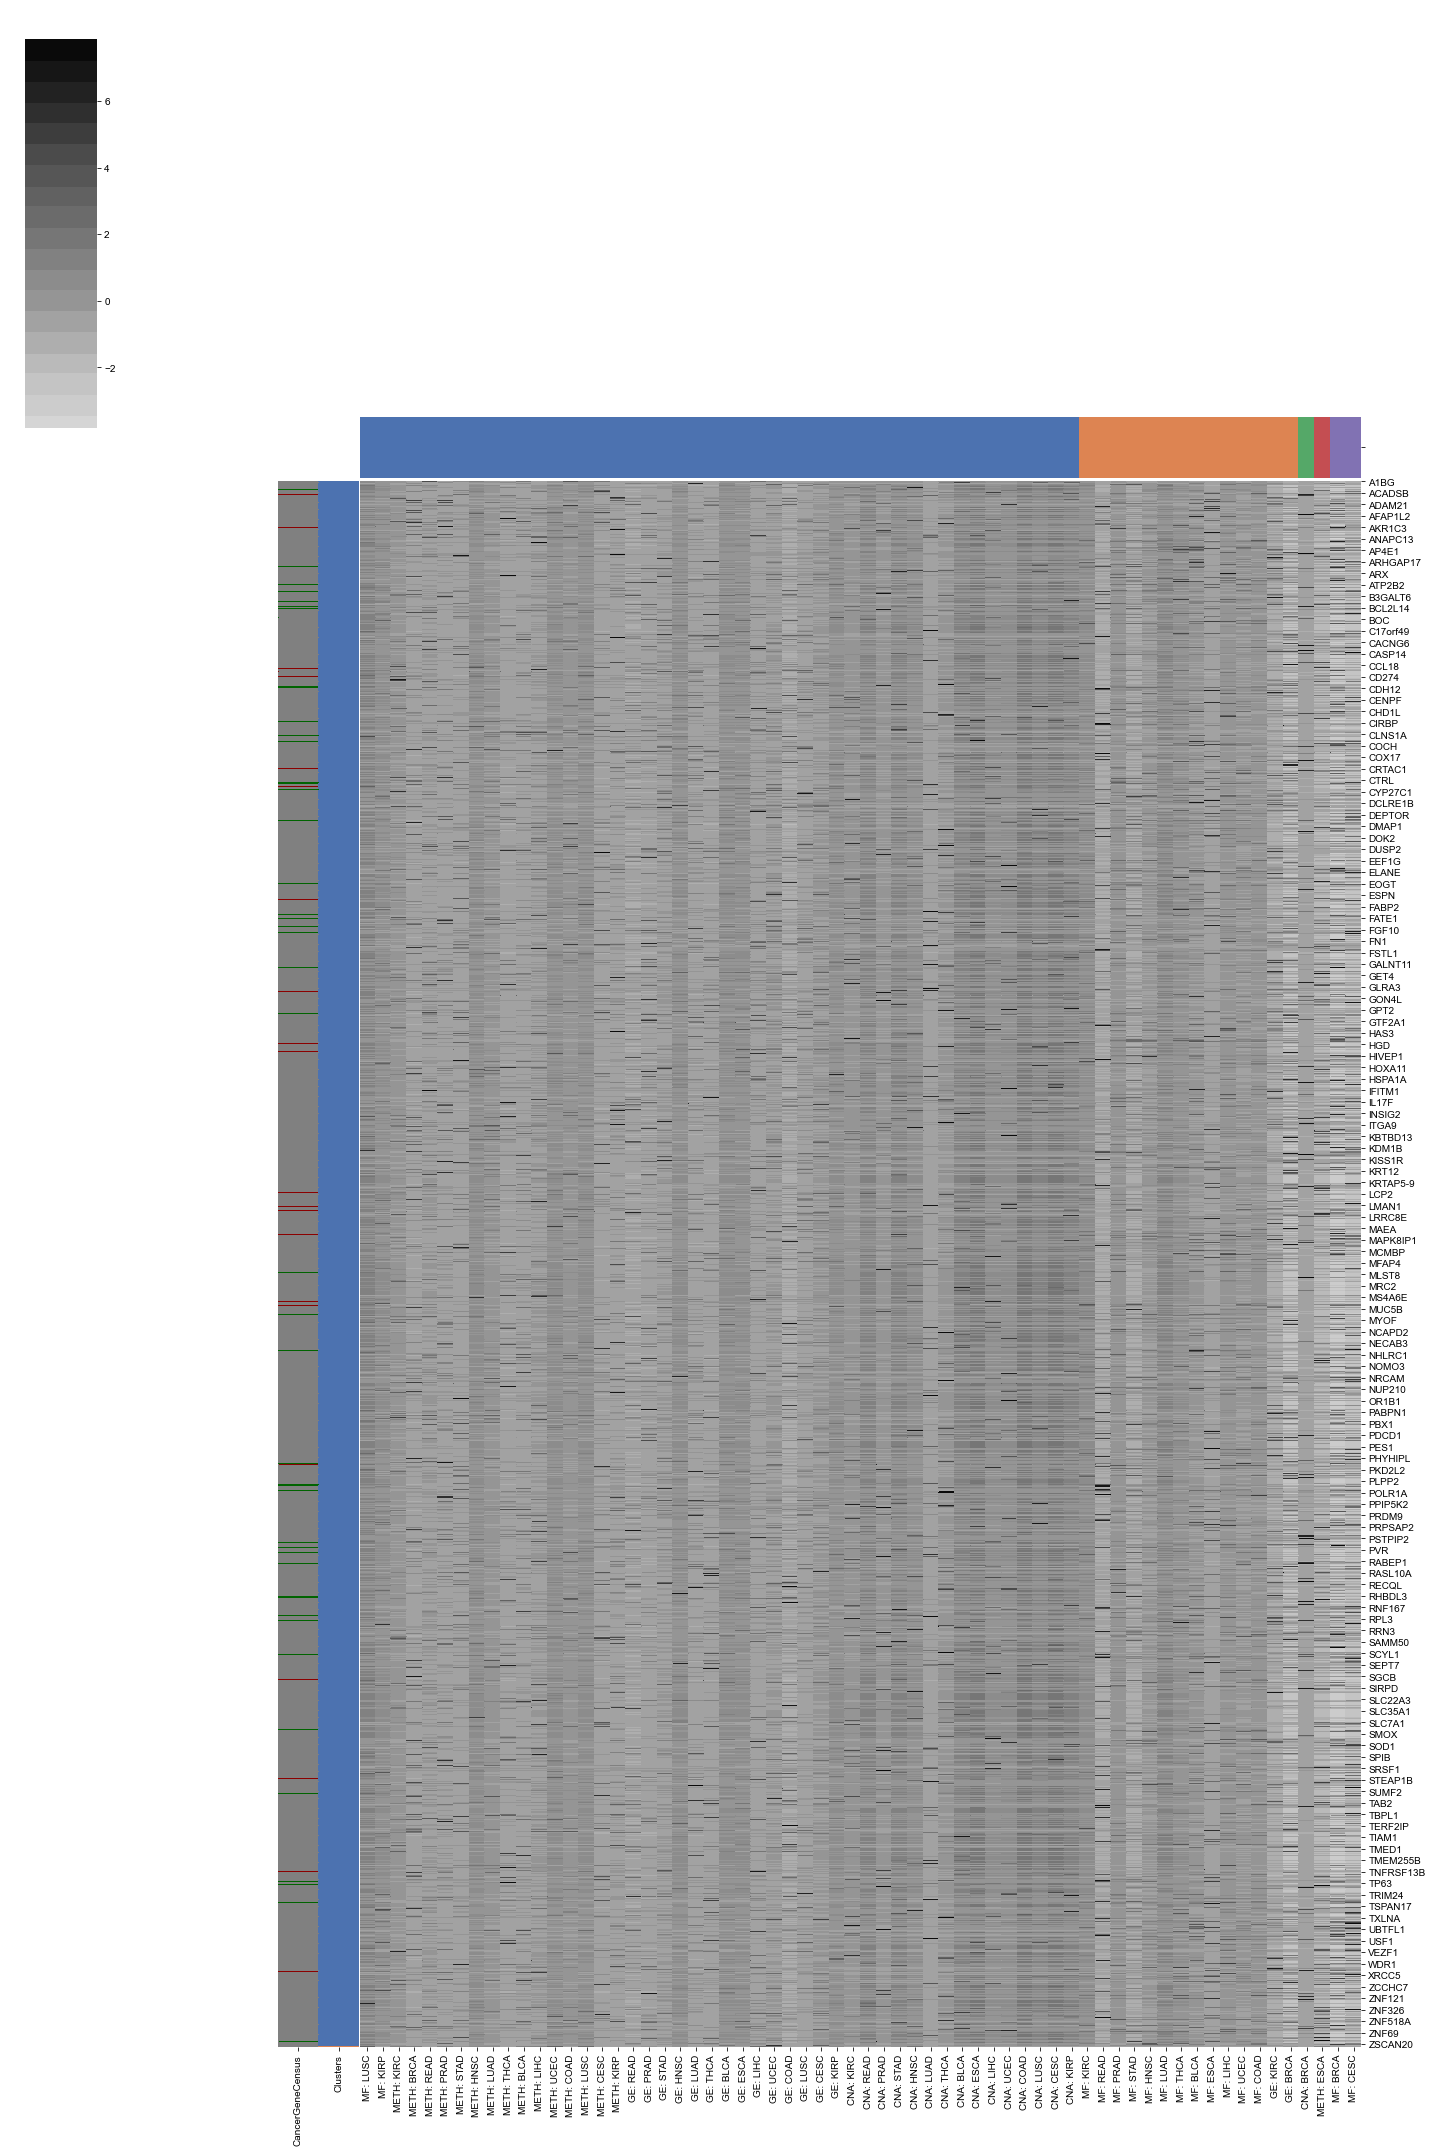

In [92]:
# remove negative contributions
feat_contrib_capped = feat_contrib_df.copy()
feat_contrib_capped[feat_contrib_capped < 0] = 0

# do the spectral biclustering
n_clusters = (2, 5)
feat_contrib_df_normed = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(feat_contrib_capped),
                                      index=feat_contrib_capped.index, columns=feat_contrib_capped.columns)
model = SpectralBiclustering(n_clusters=n_clusters, method='bistochastic',
                             svd_method='randomized', n_jobs=-1, random_state=0
                            )
model.fit(feat_contrib_df_normed)

# get new row and column orders
newOrder_row = [list(r) for r in zip(model.row_labels_, feat_contrib_df_normed.index)]
newOrder_row.sort(key=lambda k: (k[0], k[1]), reverse=False)
order_row = [i[1] for i in newOrder_row]
newOrder_col = [list(c) for c in zip(model.column_labels_, feat_contrib_df_normed.columns)]
newOrder_col.sort(key=lambda k: k[0], reverse=False)
order_col = [i[1] for i in newOrder_col]

# reorder the data matrix
X_plot = feat_contrib_df_normed.copy()
X_plot = X_plot.reindex(order_row) # rows
X_plot = X_plot[[str(x) for x in order_col]] # columns

# get the clusters as colormaps to show on the side
lut_flatclu = dict(zip(list(range(max(n_clusters))),
                       sns.color_palette("deep", n_colors=max(n_clusters)))
                  )
sns.palplot(lut_flatclu.values())

# get some information on known cancer genes (oncogenes vs TSGs vs unknown)
cgc = pd.read_csv(cgc_path).set_index('Gene Symbol')
onco_tsg_annotation = np.zeros(feat_contrib_df_normed.shape[0])
onco_tsg_annotation[feat_contrib_df_normed.index.isin(cgc[cgc['Role in Cancer'].str.contains('oncogene') == True].index)] = 1
onco_tsg_annotation[feat_contrib_df_normed.index.isin(cgc[cgc['Role in Cancer'].str.contains('TSG') == True].index)] = 2
onco_tsg_annotation = pd.Series(onco_tsg_annotation, index=feat_contrib_df_normed.index, name='CancerGeneCensus')

lut = dict(zip(onco_tsg_annotation.unique(), ['grey', 'darkred', 'darkgreen']))
onco_tsg_colors = onco_tsg_annotation.map(lut)

row_cluster_colors = pd.Series(model.row_labels_, index=feat_contrib_df_normed.index).map(lut_flatclu).rename('Clusters')
row_colors = pd.concat([onco_tsg_colors, row_cluster_colors], axis=1)

# use clustermap without clustering
cm=sns.clustermap(X_plot, method=None, metric='euclidean',
                  #cmap="RdBu_r",
                  cmap=sns.color_palette("Greys", n_colors=25),
                  row_cluster=False, col_cluster=False,
                  row_colors=row_colors,
                  col_colors=pd.Series(model.column_labels_, index=feat_contrib_df_normed.columns).map(lut_flatclu),
                  yticklabels=100, xticklabels=1,
                  figsize=(20, 30),
                  standard_scale=None, z_score=False, robust=False, center=0
                 )
cm.savefig(os.path.join(model_dir, 'biclustering_all_genes.png'), dpi=300)

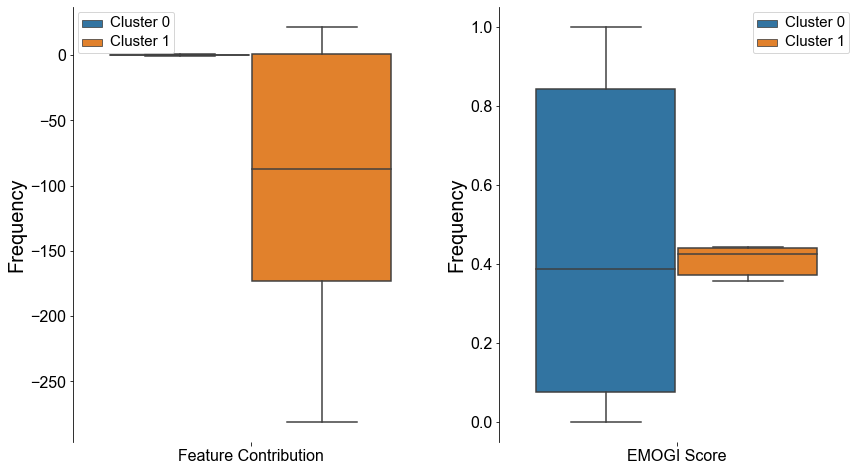

In [93]:
feature_contribs_sum = X_plot.sum(axis=1).rename('Feature_Sum')

n_clusters_boxplots = 2
nodes_with_cluster = nodes.copy()
nodes_cluster_pred = nodes_with_cluster.join(pred.drop('Name', axis=1), on='ID').set_index('Name')
nodes_enriched = nodes_cluster_pred.join(feat_contrib_df.sum(axis=1).rename('Feature_Contribution'))
nodes_enriched.loc[nodes_enriched.label.isnull(), 'label'] = 0
nodes_enriched.loc[nodes_enriched.label == True, 'label'] = 1
nodes_enriched.loc[nodes_enriched.label == False, 'label'] = 0
nodes_enriched.reindex(X_plot.index)
nodes_enriched['Cluster'] = model.row_labels_
cluster_label_list = ['Cluster {}'.format(i) for i in range(n_clusters_boxplots)]

fig = plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
g = sns.boxplot(data=pd.melt(nodes_enriched[['Feature_Contribution', 'Cluster', 'ID']], id_vars=['ID', 'Cluster']),
            x='variable', y='value', hue='Cluster', showfliers=False)
plt.xlabel(None)
plt.ylabel('Frequency', fontsize=20)
for t, l in zip(g.legend().texts, cluster_label_list):
    t.set_text(l)
    t.set_size(15)
plt.gca().set_xticklabels(['Feature Contribution'])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
#plt.gca().get_xaxis().set_visible(False)
plt.gca().tick_params(axis='both', labelsize=16)

plt.subplot(1, 2, 2)
g = sns.boxplot(data=pd.melt(nodes_enriched[['Prob_pos', 'Cluster', 'ID']], id_vars=['ID', 'Cluster']),
            x='variable', y='value', hue='Cluster', showfliers=False)
plt.xlabel(None)
plt.ylabel('Frequency', fontsize=20)
for t, l in zip(g.legend().texts, cluster_label_list):
    t.set_text(l)
    t.set_size(15)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
#plt.gca().get_xaxis().set_visible(False)
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels(['EMOGI Score'])
fig.savefig(os.path.join(model_dir, 'biclustering_{}_clusters_difference_allgenes.svg'.format(n_clusters_boxplots)))

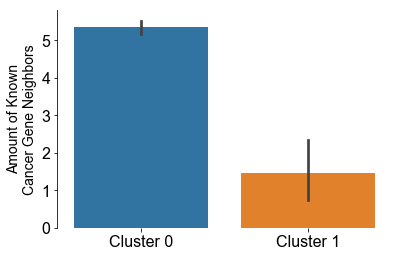

In [46]:
fig = plt.figure(figsize=(6, 4))
A = pd.DataFrame(adjacency, index=node_names[:, 1], columns=node_names[:, 1])
num_known_neighbors = A[A.index.isin(pred[pred.label == True].Name)].sum(axis=0).rename('Num_Cancer_Gene_Neighbors')
sns.barplot(data=nodes_enriched.join(num_known_neighbors)[['Cluster', 'Num_Cancer_Gene_Neighbors']], x='Cluster', y='Num_Cancer_Gene_Neighbors')
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels(cluster_label_list)
plt.ylabel('Amount of Known\nCancer Gene Neighbors', fontsize=14)
plt.xlabel(None)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
#fig.savefig(os.path.join(model_dir, 'biclustering_{}_clusters_cancerneighbors_allgenes.svg'.format(n_clusters_boxplots)))

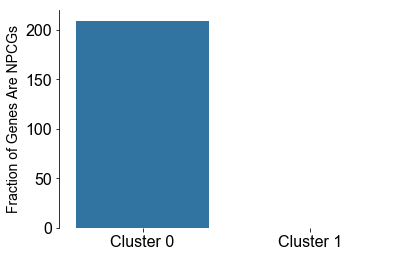

In [47]:
fig = plt.figure(figsize=(6, 4))
npcgs = pd.read_csv('../data/GCN/training/final_TCGA_all_networks/consensus_candidates.tsv', sep='\t')
npcgs.set_index('Name', inplace=True)
nodes_enriched['NPCG'] = 0
nodes_enriched.loc[nodes_enriched.index.isin(npcgs.index), 'NPCG'] = 1
npcgs_cl = [nodes_enriched[nodes_enriched.Cluster == i].NPCG.sum() for i in range(n_clusters_boxplots)]
sns.barplot(x=cluster_label_list, y=npcgs_cl)
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels(cluster_label_list)
plt.ylabel('Fraction of Genes Are NPCGs', fontsize=14)
plt.xlabel(None)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
#fig.savefig(os.path.join(model_dir, '{}_clusters_npcgs_allgenes.svg'.format(n_clusters_boxplots)))

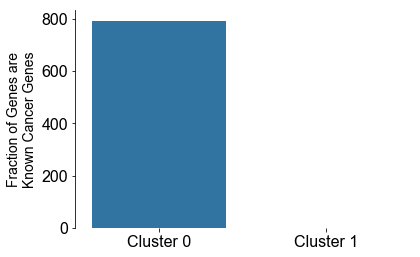

In [48]:
fig = plt.figure(figsize=(6, 4))
cgs = [nodes_enriched[nodes_enriched.Cluster == i].label.sum() for i in range(n_clusters_boxplots)]
#sns.barplot(data=nodes_enriched[['Cluster', 'label']], x='Cluster', y='label')
sns.barplot(x=cluster_label_list, y=cgs)
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels(cluster_label_list)
plt.ylabel('Fraction of Genes are\nKnown Cancer Genes', fontsize=14)
plt.xlabel(None)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
#fig.savefig(os.path.join(model_dir, '{}_clusters_literature_allgenes.svg'.format(n_clusters_boxplots)))

## Plot All Features for Row-Clusters
This is just to see the complete picture of the genes in each cluster.

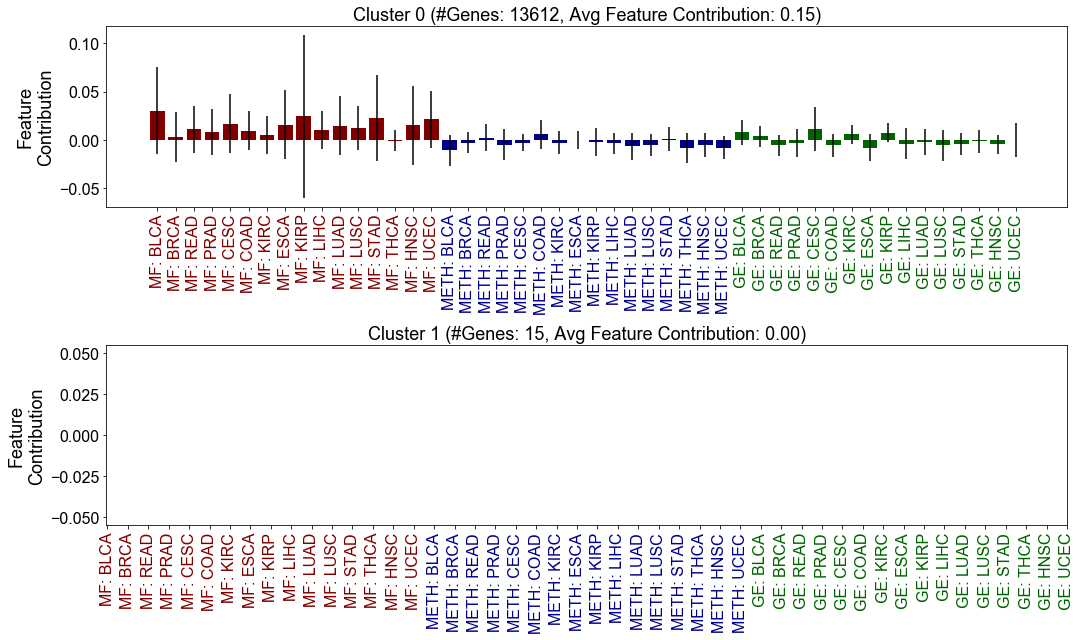

In [69]:
sum_of_all = 0
n_clusters = nodes_enriched.Cluster.nunique()
fig, axes = plt.subplots(nrows=n_clusters, ncols=1,
                         figsize=(15, n_clusters*3 + 3)
                         #gridspec_kw={'width_ratios': [3, 1]}
                        )
def plot_representative_heatmap(ax, rep, xlabels, title=None):
    rep = rep.reshape(16, 3, order='F')
    inner = gridspec.GridSpecFromSubplotSpec(3, 1, hspace=0, subplot_spec=ax)
    omics = ['Mutation', 'Methylation', 'Expression']
    cmaps = [sns.color_palette("Reds"), sns.color_palette("Blues"), sns.color_palette("Greens")]
    vmax = rep.max()
    vmin = rep.min()
    print ("Max and min ", vmax, vmin)
    for c in range(3):
        ax = plt.Subplot(fig, inner[c])
        xticklabels = False
        if c == 2:
            xticklabels = [i.split(':')[1] for i in xlabels[:16]]
        sns.heatmap(rep[:, c].reshape(1, -1), ax=ax, xticklabels=xticklabels,
                    cbar=False, cmap=cmaps[c],
                    cbar_kws={'use_gridspec': False, 'orientation': 'vertical'},
                    vmax=vmax, vmin=vmin)
        ax.set_yticklabels([omics[c]], rotation=0, fontsize=10)
        if not title is None and c == 0:
            ax.set_title(title, fontsize=16)
        fig.add_subplot(ax)
    plt.subplots_adjust(bottom=0.05, hspace=0.05, wspace=0)


for cluster_number in nodes_enriched.Cluster.unique():
    # find the genes in the current cluster
    cluster_genes = nodes_enriched[nodes_enriched.Cluster == cluster_number].index
    
    # compute the representative for that cluster
    features_of_cluster = high_feat_contrib[high_feat_contrib.index.isin(cluster_genes)]
    representative = features_of_cluster.mean(axis=0)
    representative_std = features_of_cluster.std(axis=0)
    # plot barplot for representative
    plot_representative(axes[cluster_number], representative, representative_std, representative.index,
             title='Cluster {0} (#Genes: {1}, Avg Feature Contribution: {2:.2f})'.format(cluster_number,
                                                                                         cluster_genes.shape[0],
                                                                                         representative.sum()
                                                                                        )
            )
plt.tight_layout()
#fig.savefig(os.path.join(model_dir, 'cluster_representatives_highconf_{}.pdf'.format(flat_clusters_series.nunique())))

## Are Newly Predicted Cancer Genes Interaction or Feature Driven?

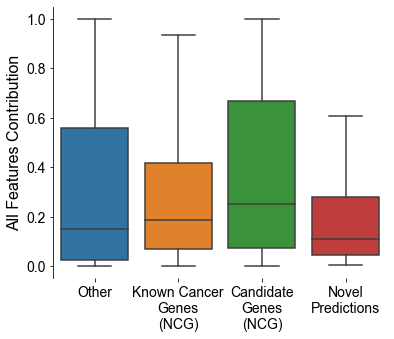

In [205]:
npcgs = pd.read_csv('../data/GCN/training/Rev1_CNA_separated_all_networks/consensus_candidates_cnasep.tsv', sep='\t')
#npcgs = pd.read_csv('../data/GCN/training/final_TCGA_all_networks/consensus_candidates.tsv', sep='\t')
oncokb, known, candidate = get_cancer_genes()
npcgs.set_index('Name', inplace=True)
contribution_sum_df = pd.DataFrame(feat_contrib_df.sum(axis=1), columns=['Feature_Sum'])
contribution_sum_df['Gene_Set'] = 'Other'
#contribution_sum_df.loc[contribution_sum_df.index.isin(candidate), 'Gene_Set'] = 'Candidate\nCancer Gene'
#contribution_sum_df.loc[contribution_sum_df.index.isin(oncokb['Hugo Symbol']), 'Gene_Set'] = 'OncoKB'
contribution_sum_df.loc[contribution_sum_df.index.isin(known), 'Gene_Set'] = 'Known Cancer\nGenes\n(NCG)'
contribution_sum_df.loc[contribution_sum_df.index.isin(candidate), 'Gene_Set'] = 'Candidate\nGenes\n(NCG)'
contribution_sum_df.loc[contribution_sum_df.index.isin(npcgs.index), 'Gene_Set'] = 'Novel\nPredictions'
contribution_sum_df.Gene_Set.value_counts()
contribution_sum_df.Feature_Sum = contribution_sum_df.Feature_Sum.abs()
contribution_sum_df.loc[contribution_sum_df.Feature_Sum > 1, 'Feature_Sum'] = 1

fig = plt.figure(figsize=(6, 5))
sns.boxplot(data=contribution_sum_df, x='Gene_Set', y='Feature_Sum', showfliers=False, 
            order=['Other', 'Known Cancer\nGenes\n(NCG)', 'Candidate\nGenes\n(NCG)', 'Novel\nPredictions'])
plt.ylabel('All Features Contribution', fontsize=16)
plt.xlabel(None)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().tick_params(axis='both', labelsize=14)
fig.savefig(os.path.join(model_dir, 'feature_contribution_npcgs.svg'))

In [89]:
contrib_df_copy = feat_contrib_df.copy()
contrib_df_copy[contrib_df_copy < 0] = 0
contrib_df_copy.loc['Omics_Type', :] = [i[0] for i in feat_contrib_df.columns.str.split(':')]
omics_contributions = contrib_df_copy.T.groupby('Omics_Type').sum().T

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def minmax(x):
    return x / x.sum(axis=0)
omics_contributions_probs = omics_contributions.apply(minmax, axis=1)

In [90]:
omics_contributions_probs['Gene_Set'] = 'Other'
omics_contributions_probs.loc[omics_contributions_probs.index.isin(known), 'Gene_Set'] = 'Known Cancer\nGenes\n(NCG)'
omics_contributions_probs.loc[omics_contributions_probs.index.isin(candidate), 'Gene_Set'] = 'Candidate\nGenes\n(NCG)'
omics_contributions_probs.loc[omics_contributions_probs.index.isin(high_feat_contrib.index), 'Gene_Set'] = 'Top 1000\nPredictions'
omics_contributions_probs.loc[omics_contributions_probs.index.isin(npcgs.index), 'Gene_Set'] = 'Novel\nPredictions'

In [91]:
omics_contributions_probs.Gene_Set.value_counts()

Other                         11166
Candidate\nGenes\n(NCG)        1070
Top 1000\nPredictions           875
Known Cancer\nGenes\n(NCG)      358
Novel\nPredictions              158
Name: Gene_Set, dtype: int64

In [115]:
assert ((omics_contributions_probs.index == contribution_sum_df.index).all())
omics_contributions_highconf = omics_contributions_probs #omics_contributions_probs[contribution_sum_df.Feature_Sum > 0.05]
omics_contributions_highconf.Gene_Set.value_counts()

Other                         11166
Candidate\nGenes\n(NCG)        1070
Top 1000\nPredictions           875
Known Cancer\nGenes\n(NCG)      358
Novel\nPredictions              158
Name: Gene_Set, dtype: int64

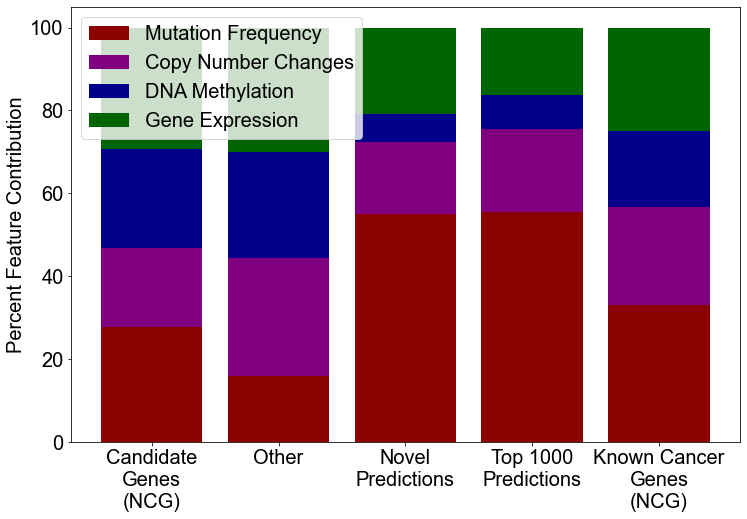

In [117]:
stacked_barplot_vals = {}
gene_sets = omics_contributions_highconf.Gene_Set.unique()
groups = list(range(len(gene_sets)))
for omics in ['MF', 'CNA', 'METH', 'GE']:
    omics_vals = []
    for gene_set in gene_sets:
        omics_vals.append(omics_contributions_highconf.loc[omics_contributions_highconf.Gene_Set == gene_set, omics].mean())
    stacked_barplot_vals[omics] = omics_vals

df = pd.DataFrame(stacked_barplot_vals)
totals = [i+j+k+l for i,j,k,l in zip(df['MF'], df['CNA'], df['METH'], df['GE'])]
mutation_bars = [i / j * 100 for i,j in zip(df['MF'], totals)]
cna_bars = [i / j * 100 for i,j in zip(df['CNA'], totals)]
methylation_bars = [i / j * 100 for i,j in zip(df['METH'], totals)]
expression_bars = [i / j * 100 for i,j in zip(df['GE'], totals)]

fig = plt.figure(figsize=(12, 8))
plt.bar(groups, mutation_bars, color='darkred', label='Mutation Frequency')
plt.bar(groups, cna_bars, bottom=mutation_bars, color='purple', label='Copy Number Changes')
plt.bar(groups, methylation_bars, bottom=[i+j for i,j in zip(mutation_bars, cna_bars)],
                                          color='darkblue', label='DNA Methylation')
plt.bar(groups, expression_bars, bottom=[i+j+k for i,j,k in zip(mutation_bars, cna_bars, methylation_bars)],
        color='darkgreen', label='Gene Expression')

plt.legend(loc='upper left', ncol=1, fontsize=20)
plt.ylabel('Percent Feature Contribution', fontsize=20)
_ = plt.xticks(groups, gene_sets, fontsize=12)
plt.gca().tick_params(axis='both', which='major', labelsize=20)
fig.savefig(os.path.join(model_dir, 'omics_contributions_genesets.svg'))

## Compute Omics Contributions for Top 1000 Genes with Important Interaction Partners

In [54]:
lrp_neighbor_matrix = np.load(os.path.join(model_dir, 'lrp_sigmoid', 'support_0_mean_sum.npy'))
count = 1
for i in range(5):
    p = os.path.join(model_dir, 'lrp_sigmoid', 'support_{}_mean_sum.npy'.format(i))
    if os.path.isfile(p):
        lrp_neighbor_matrix += np.load(p)
        count += 1
        print ("Loaded and added neighbor contributions with support {}".format(i))
lrp_neighbor_matrix = lrp_neighbor_matrix / float(count)

lrp_neighbor_matrix[lrp_neighbor_matrix < 0] = 0

lrp_neighbors = pd.DataFrame(lrp_neighbor_matrix, index=node_names[:, 1], columns=node_names[:, 1])

Loaded and added neighbor contributions with support 0
Loaded and added neighbor contributions with support 1


In [56]:
# make the omics contributions nice and add the network contribution to it
omics_contributions_highconf = omics_contributions_probs.loc[omics_contributions_probs.index.isin(high_feat_contrib.index), :]
omics_contributions_highconf.drop('Gene_Set', inplace=True, axis=1)
omics_contributions_highconf.columns = ['Gene Expression', 'Copy Number Changes', 'DNA Methylation at Promoters', 'Mutation Frequencies']
omics_contributions_with_network_contrib = omics_contributions_highconf.join(pd.Series(1 - high_feat_contrib.sum(axis=1),
                                                                                       name='Network Contribution')
                                                                            )

# compute the top 5 neighbors for all the genes and add to the data frame
top_ip_all = []
for name, row in omics_contributions_highconf.iterrows():
    ip_contribs = lrp_neighbors[lrp_neighbors.index == name].T
    ip_contribs.drop(name, inplace=True)
    ip_contribs.columns = ['Contributions']
    top_neighbors = ip_contribs.sort_values(by='Contributions', ascending=False).head(5)
    top_ip_all.append(top_neighbors.index.tolist())
most_important_neighbors = pd.DataFrame(top_ip_all, index=omics_contributions_highconf.index,
                                        columns=['Interaction Partner {}'.format(i+1) for i in range(5)]
                                       )
omics_contributions_top_1000 = omics_contributions_with_network_contrib.join(most_important_neighbors)

# write to file
omics_contributions_top_1000.to_csv(os.path.join(model_dir, 'omics_contributions_top1000.tsv'), sep='\t')
omics_contributions_top_1000.head()

,Gene Expression,Copy Number Changes,DNA Methylation at Promoters,Mutation Frequencies,Network Contribution,Interaction Partner 1,Interaction Partner 2,Interaction Partner 3,Interaction Partner 4,Interaction Partner 5
GRB2,0.417,0.402,0.006,0.175,0.940,PIK3CA,C6,ENPP3,RYR1,DST
GAB1,0.000,0.509,0.212,0.279,1.021,PIK3CA,TNS1,MAPK4,BMX,PARD3
EGFR,0.449,0.023,0.010,0.518,1.030,EYS,MUC16,PCDHGA3,TTN,DNAH7
PIK3CA,0.035,0.000,0.000,0.964,0.102,KRAS,CNOT3,TNFSF13,FBP2,RPS6KB1
PIK3R1,0.140,0.003,0.000,0.857,0.897,PIK3CA,TIE1,CYP4A11,PROM1,DLGAP2


## Sanity Check: Compare LRP with the Results from Before

In [7]:
feat_contrib_df.head()

,MF: KIRC,MF: BRCA,MF: READ,MF: PRAD,MF: STAD,MF: HNSC,MF: LUAD,MF: THCA,MF: BLCA,MF: ESCA,...,CNA: LUAD,CNA: THCA,CNA: BLCA,CNA: ESCA,CNA: LIHC,CNA: UCEC,CNA: COAD,CNA: LUSC,CNA: CESC,CNA: KIRP
STIM1,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.004,-0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.006,0.000
TRPC1,0.000,0.005,0.000,0.042,0.000,0.019,0.069,0.000,0.000,0.045,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
NOS1,0.020,0.005,-0.005,0.011,0.021,0.007,0.014,0.000,0.020,0.000,...,0.031,0.000,0.000,0.000,0.000,0.000,0.000,0.027,0.000,0.000
ATP2B4,0.013,0.007,-0.003,0.030,0.005,0.011,0.027,0.002,0.000,0.000,...,0.000,-0.219,-0.047,0.000,0.000,0.000,0.000,0.000,0.000,0.000
ABCC9,-0.155,0.016,-0.131,-0.545,-1.226,0.045,0.255,-0.015,-0.800,0.212,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [12]:
m_dir = '../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/'
args, _ = gcnIO.load_hyper_params(m_dir)
hdf_path = os.path.join(m_dir, args['data'])
with h5py.File(hdf_path, 'r') as f:
    node_names = f['gene_names'][:]
    feature_names = f['feature_names'][:]
    adjacency = f['network'][:]
    features = f['features'][:]
    features_raw = f['features_raw'][:]
feature_contributions_old = np.load(os.path.join(m_dir, 'lrp_sigmoid', 'feat_mean_all.npy'))
# replace 0 values with small random ones to prevent numerical issues
feat_contrib_df_old = pd.DataFrame(feature_contributions_old, index=node_names[:feature_contributions_old.shape[0], 1], columns=feature_names)
zero_rows = feat_contrib_df_old[(feat_contrib_df_old == 0).all(axis=1)]
print (zero_rows.shape)
feat_contrib_df_old.loc[(feat_contrib_df_old == 0).all(axis=1)] = np.random.randn(*zero_rows.shape)*0.00001
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])

(236, 48)


In [18]:
(feat_contrib_df.index == feat_contrib_df_old.index).all()

True

In [61]:
spearman_corr_cols = []
for col in feat_contrib_df_old.columns:
    r = scipy.stats.spearmanr(feat_contrib_df[col], feat_contrib_df_old[col])[0]
    spearman_corr_cols.append(r)
    print ("{0}: Correlation: {1:.3f}".format(col, r))

MF: BLCA: Correlation: 0.352
MF: BRCA: Correlation: 0.119
MF: READ: Correlation: 0.209
MF: PRAD: Correlation: 0.368
MF: CESC: Correlation: 0.261
MF: COAD: Correlation: 0.403
MF: KIRC: Correlation: 0.321
MF: ESCA: Correlation: 0.240
MF: KIRP: Correlation: 0.172
MF: LIHC: Correlation: 0.351
MF: LUAD: Correlation: 0.319
MF: LUSC: Correlation: 0.220
MF: STAD: Correlation: 0.362
MF: THCA: Correlation: -0.033
MF: HNSC: Correlation: 0.302
MF: UCEC: Correlation: 0.392
METH: BLCA: Correlation: 0.252
METH: BRCA: Correlation: 0.195
METH: READ: Correlation: 0.193
METH: PRAD: Correlation: 0.227
METH: CESC: Correlation: 0.159
METH: COAD: Correlation: 0.265
METH: KIRC: Correlation: 0.229
METH: ESCA: Correlation: 0.172
METH: KIRP: Correlation: 0.177
METH: LIHC: Correlation: 0.177
METH: LUAD: Correlation: 0.264
METH: LUSC: Correlation: 0.222
METH: STAD: Correlation: 0.162
METH: THCA: Correlation: 0.286
METH: HNSC: Correlation: 0.233
METH: UCEC: Correlation: 0.249
GE: BLCA: Correlation: 0.183
GE: BRCA: 

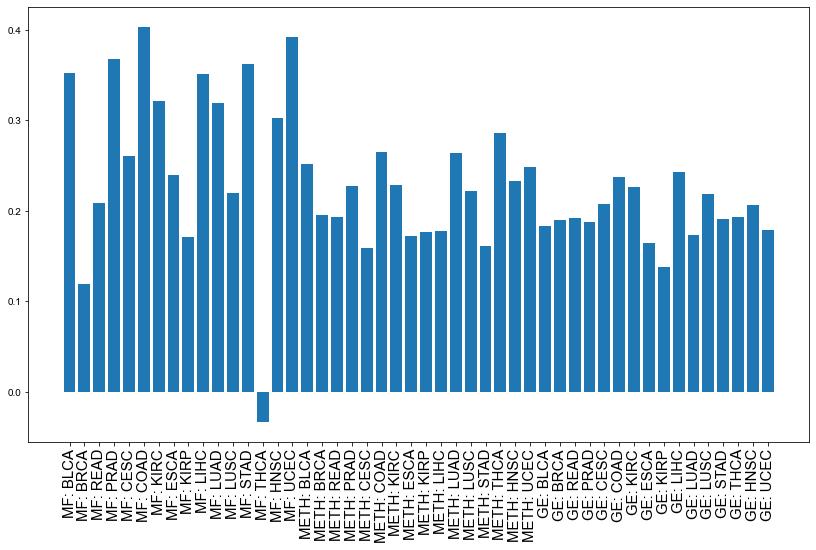

In [67]:
fig = plt.figure(figsize=(14, 8))
plt.bar(x=feat_contrib_df_old.columns, height=spearman_corr_cols)
_ = plt.xticks(rotation=90, fontsize=15)

In [149]:
high_conf_genes = high_feat_contrib.index
c = 0
all_rs = []
all_pvals = []
feat_contrib_threeomics = feat_contrib_df[feat_contrib_df_old.columns]
feat_contrib_df_old_high = feat_contrib_df_old[feat_contrib_df_old.index.isin(high_conf_genes)]
for idx, row in feat_contrib_df_old_high.iterrows():
    #print (row.shape, feat_contrib_threeomics[feat_contrib_threeomics.index == idx].shape)
    r, pval = scipy.stats.spearmanr(row, feat_contrib_threeomics[feat_contrib_threeomics.index == idx].values.reshape(-1))
    all_rs.append(r)
    all_pvals.append(pval)
    c += 1

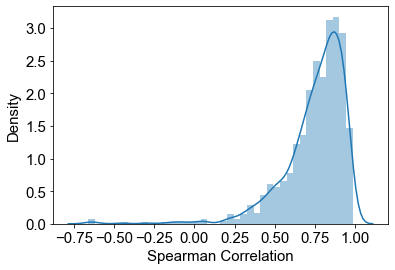

In [150]:
sns.distplot(all_rs)
plt.ylabel('Density', fontsize=15)
plt.xlabel('Spearman Correlation', fontsize=15)
_ = plt.xticks(fontsize=15)
_ = plt.yticks(fontsize=15)

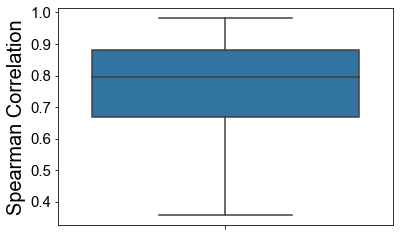

In [151]:
sns.boxplot(all_rs, orient='v', showfliers=False)
plt.ylabel('Spearman Correlation', fontsize=20)
_ = plt.yticks(fontsize=15)

<AxesSubplot:>

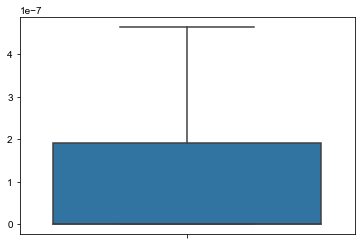

In [152]:
sns.boxplot(all_pvals, showfliers=False, orient='v')

In [153]:
np.median([i for i in all_pvals if not np.isnan(i)])

1.611162113021781e-11

In [154]:
print ("Median R for Spearman Correlation for genes:")
np.median([i for i in all_rs if not np.isnan(i)]), len([i for i in all_rs if not np.isnan(i)])

Median R for Spearman Correlation for genes:


(0.7942978144266312, 997)